<a href="https://colab.research.google.com/github/Faza20-lab/Projet_stats/blob/1980-2023/Projet_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **I/ Preset**

In [1]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.0 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import scipy.stats as st
from scipy.stats import norm, gamma, beta, shapiro, kstest, genextreme, genpareto, probplot, kendalltau, rankdata, multivariate_normal, multivariate_t
import statsmodels.api as sm
from statsmodels.stats.diagnostic import anderson_statistic
from scipy.stats import beta as beta_dist
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.integrate import quad
from scipy.optimize import root_scalar, brentq
from scipy.special import gammaln
from scipy.stats import t as student_t

In [3]:
from google.colab import drive
drive.mount('/content/drive')

file_prec = '/content/drive/MyDrive/data/ERA5_prec_daily_1940_2023_FR_brittany.nc'
ds = xr.open_dataset(file_prec)

Mounted at /content/drive


# **II/ Visualisation des données:**


## Visualisation des données de precipitations et définition de X:

In [4]:
ds.sizes

Frozen({'Latitude': 12, 'Longitude': 14, 'time': 30449})

In [5]:
print(ds['time'])

<xarray.DataArray 'time' (time: 30449)> Size: 244kB
array(['1940-01-01T00:00:00.000000000', '1940-01-02T00:00:00.000000000',
       '1940-01-03T00:00:00.000000000', ..., '2023-05-11T00:00:00.000000000',
       '2023-05-12T00:00:00.000000000', '2023-05-13T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 244kB 1940-01-01 1940-01-02 ... 2023-05-13
    height   float64 8B ...


In [6]:
ds.time.values[:10]

array(['1940-01-01T00:00:00.000000000', '1940-01-02T00:00:00.000000000',
       '1940-01-03T00:00:00.000000000', '1940-01-04T00:00:00.000000000',
       '1940-01-05T00:00:00.000000000', '1940-01-06T00:00:00.000000000',
       '1940-01-07T00:00:00.000000000', '1940-01-08T00:00:00.000000000',
       '1940-01-09T00:00:00.000000000', '1940-01-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [7]:
print(ds.Latitude.values)
print(ds.Longitude.values)

[49.   48.75 48.5  48.25 48.   47.75 47.5  47.25 47.   46.75 46.5  46.25]
[-4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25 -2.
 -1.75 -1.5 ]


Le dataset complet (ds) contient les niveaux de précipitation en (kg/m3/s) sur toute la Bretagne par jour de 1940 à 2023.
Il y a en tout 30 449 jours.

**On trace ensuite une carte du premier jour:** 01/01/1940

In [8]:
da = ds['pr'].isel(time=0)   # sélection du premier pas de temps (un jour = une carte)
df = da.to_dataframe().reset_index() # pandas dataframe du premier jour sur toutes les long. lat. de la bretagne

In [9]:
print(da)

<xarray.DataArray 'pr' (Latitude: 12, Longitude: 14)> Size: 672B
[168 values with dtype=float32]
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
    time       datetime64[ns] 8B 1940-01-01
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...


In [10]:
print(df.head())

   Latitude  Longitude       time   lon   lat  height  pr
0      49.0      -4.75 1940-01-01 -4.75  49.0     0.0 NaN
1      49.0      -4.50 1940-01-01 -4.50  49.0     0.0 NaN
2      49.0      -4.25 1940-01-01 -4.25  49.0     0.0 NaN
3      49.0      -4.00 1940-01-01 -4.00  49.0     0.0 NaN
4      49.0      -3.75 1940-01-01 -3.75  49.0     0.0 NaN


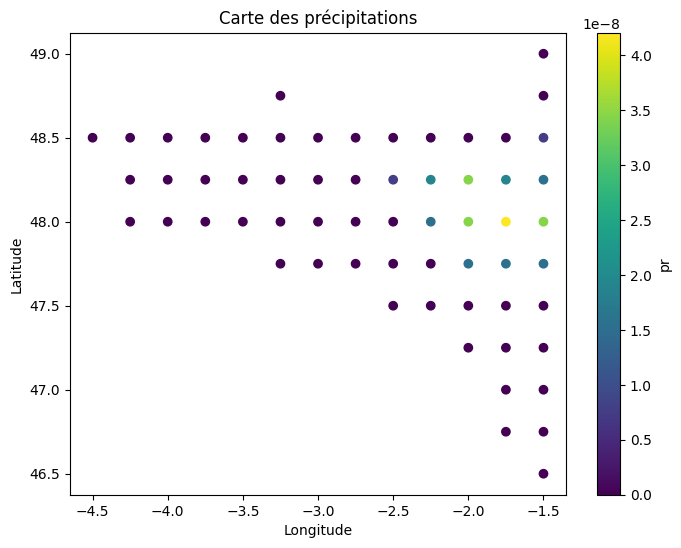

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(df["Longitude"], df["Latitude"], c=df["pr"])
plt.colorbar(label="pr")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Carte des précipitations")
plt.show()

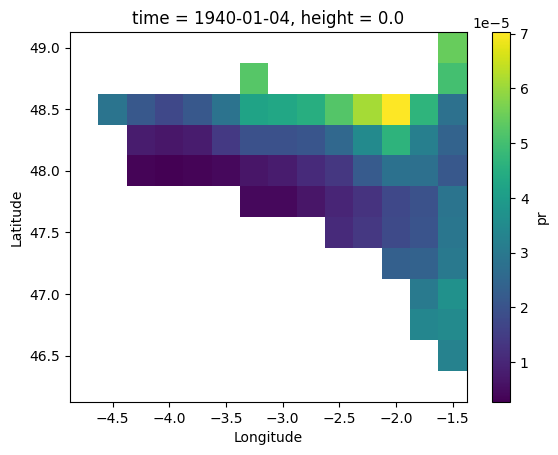

In [12]:
ds.pr[:,:,3].plot() #  On peut aussi tracer comme ça trace ici c'est le jour 4 (04/01/1940)

**Maintenant on sélectionne les mois qui nous intéressent.** Ici Décembre, janvier, février. On appelle ce dataset ds_djf.

In [13]:
ds_djf = ds.sel(time=ds['time'].dt.month.isin([1, 2, 12]))  # sélection des mois DJF
print(ds_djf)
ds_djf.sizes # dimensions du dataset

<xarray.Dataset> Size: 5MB
Dimensions:    (Latitude: 12, Longitude: 14, time: 7550)
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
  * time       (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...
Data variables:
    pr         (Latitude, Longitude, time) float32 5MB ...


Frozen({'Latitude': 12, 'Longitude': 14, 'time': 7550})

Ce dataset contient maintenant **7550 jours**.
On fait ensuite la **somme par jour des précipitations** sur toute la Bretagne, on appelle cette variable **X**.

In [14]:
# Somme quotidienne des précipitations sur toute la zone en mois DJF
somme_quotidienne_pr_djf = ds_djf['pr'].sum(dim=['Latitude', 'Longitude'])  # somme spatiale
print(somme_quotidienne_pr_djf)

X = somme_quotidienne_pr_djf
print(len(X))  # nombre de jours

<xarray.DataArray 'pr' (time: 7550)> Size: 30kB
array([2.7539758e-07, 0.0000000e+00, 3.9131618e-03, ..., 1.3772695e-05,
       2.4685731e-05, 2.1683841e-03], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
7550


In [15]:
type(X)

xarray.core.dataarray.DataArray

On **convertit** X de kg/m2/s en mm-1 et on met à jour X.

1 kg/m² = 1 mm d’eau.
Il faut donc multiplier par le nombre de secondes dans une journée.

In [16]:
print("X en kg/m2/s", X)
#conversion de kg/m²/s en mm-1
seconds_per_day = 24 * 60 * 60  # 86400

X_mm_per_day = X * seconds_per_day # x(1000/1000)

# Mettre à jour le DataArray avec une nouvelle unité
X = X_mm_per_day.rename("pr_mm_per_day")
X.attrs['units'] = 'mm/day'
X.attrs['description'] = 'Précipitation journalière convertie de kg/m²/s → mm/j'

print("X en mm-1", X)

X en kg/m2/s <xarray.DataArray 'pr' (time: 7550)> Size: 30kB
array([2.7539758e-07, 0.0000000e+00, 3.9131618e-03, ..., 1.3772695e-05,
       2.4685731e-05, 2.1683841e-03], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
X en mm-1 <xarray.DataArray 'pr_mm_per_day' (time: 7550)> Size: 30kB
array([2.3794351e-02, 0.0000000e+00, 3.3809717e+02, ..., 1.1899608e+00,
       2.1328471e+00, 1.8734839e+02], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
Attributes:
    units:        mm/day
    description:  Précipitation journalière convertie de kg/m²/s → mm/j


<xarray.Dataset> Size: 708B
Dimensions:    (Longitude: 5, Latitude: 5, time: 5)
Coordinates:
  * Longitude  (Longitude) float64 40B -4.75 -4.5 -4.25 -4.0 -3.75
  * Latitude   (Latitude) float64 40B 49.0 48.75 48.5 48.25 48.0
  * time       (time) datetime64[ns] 40B 1940-01-01 1940-01-02 ... 1940-01-05
    lon        (Longitude) float64 40B ...
    lat        (Latitude) float64 40B ...
    height     float64 8B ...
Data variables:
    pr         (Latitude, Longitude, time) float32 500B nan nan ... 0.01967


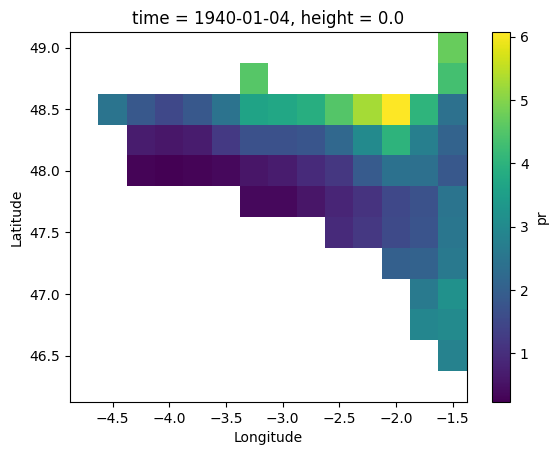

In [17]:
ds_djf['pr'] = ds['pr'] * 86400  # on convertit aussi le dataset en mm-1
ds_djf.pr[:,:,3].plot()
print(ds_djf.head())

## Visualisation des données de vents et définition de Y:

In [18]:
file_wind = '/content/drive/MyDrive/data/ERA5_wind_daily_1940_2023_FR_brittany.nc'
ds2 = xr.open_dataset(file_wind)

In [19]:
ds2.head()

<xarray.Dataset> Size: 708B
Dimensions:    (Latitude: 5, Longitude: 5, time: 5)
Coordinates:
  * Latitude   (Latitude) float64 40B 49.0 48.75 48.5 48.25 48.0
  * Longitude  (Longitude) float64 40B -4.75 -4.5 -4.25 -4.0 -3.75
  * time       (time) datetime64[ns] 40B 1940-01-01 1940-01-02 ... 1940-01-05
    lon        (Longitude) float64 40B ...
    lat        (Latitude) float64 40B ...
    height     float64 8B ...
Data variables:
    sfcWind    (Latitude, Longitude, time) float32 500B ...

In [20]:
ds2.time.values[:10]

array(['1940-01-01T00:00:00.000000000', '1940-01-02T00:00:00.000000000',
       '1940-01-03T00:00:00.000000000', '1940-01-04T00:00:00.000000000',
       '1940-01-05T00:00:00.000000000', '1940-01-06T00:00:00.000000000',
       '1940-01-07T00:00:00.000000000', '1940-01-08T00:00:00.000000000',
       '1940-01-09T00:00:00.000000000', '1940-01-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

Le dataset complet (ds2) contient les maximums de vent par jour (m/s) sur toute la Bretagne de 1940 à 2023.
Il y a en tout 30 449 jours.

On ne garde ensuite que décembre, janvier, février (7550jours).

In [21]:
ds2_djf = ds2.sel(time=ds2['time'].dt.month.isin([1, 2, 12]))  # sélection des mois DJF
print(ds2_djf)
ds2_djf.sizes

<xarray.Dataset> Size: 5MB
Dimensions:    (Latitude: 12, Longitude: 14, time: 7550)
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
  * time       (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...
Data variables:
    sfcWind    (Latitude, Longitude, time) float32 5MB ...


Frozen({'Latitude': 12, 'Longitude': 14, 'time': 7550})

On définit la variable Y qui correspond à la moyenne spatiale (sur la Bretagne) des vitesses de vent.

In [22]:
# Moyenne quotidienne du vent de surface sur la zone (DJF)
mean_quotidienne_sfcWind_djf = ds2_djf['sfcWind'].mean(dim=['Latitude', 'Longitude'])
print(mean_quotidienne_sfcWind_djf)

Y = mean_quotidienne_sfcWind_djf
print(len(Y))    # nombre de jours

<xarray.DataArray 'sfcWind' (time: 7550)> Size: 30kB
array([7.83476  , 7.0278034, 6.5031533, ..., 8.036705 , 7.9032116,
       7.3788795], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
7550


On définit pour la suite un seuil d'événement extrême à 70%.

In [127]:
threshold = 90 #seuil de percentile (attention seuil quantile=0,70)

## Séparation des périodes:

On veux séparer les périodes 1940-1980 et 1980-2023 pour les comparer.

In [24]:
ds_1940_1980 = ds_djf.sel(time=slice("1940-01-01", "1979-12-31"))
ds_1980_2023 = ds_djf.sel(time=slice("1980-01-01", "2023-12-31"))

# on vérifie
print("première période: " , ds_1940_1980.time.min().values, ds_1940_1980.time.max().values)
print("deuxième période: ", ds_1980_2023.time.min().values, ds_1980_2023.time.max().values)

première période:  1940-01-01T00:00:00.000000000 1979-12-31T00:00:00.000000000
deuxième période:  1980-01-01T00:00:00.000000000 2023-02-28T00:00:00.000000000


In [25]:
# On refait la somme quotidienne des précipitations sur toute la zone en mois DJF
somme_quotidienne_pr_djf_P2= ds_1980_2023['pr'].sum(dim=['Latitude', 'Longitude'])  # somme spatiale
print(somme_quotidienne_pr_djf_P2)

X = somme_quotidienne_pr_djf_P2
print("Nombre de jours ", len(X))  # nombre de jours

<xarray.DataArray 'pr' (time: 3940)> Size: 16kB
array([483.02405  ,   1.4244189, 233.27939  , ...,   1.1899608,
         2.1328468, 187.34837  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 32kB 1980-01-01 1980-01-02 ... 2023-02-28
    height   float64 8B ...
Nombre de jours  3940


De même pour les vents.

In [26]:
ds2_1940_1980 = ds2_djf.sel(time=slice("1940-01-01", "1979-12-31"))
ds2_1980_2023 = ds2_djf.sel(time=slice("1980-01-01", "2023-12-31"))

# on vérifie
print("première période: " , ds2_1940_1980.time.min().values, ds2_1940_1980.time.max().values)
print("deuxième période: ", ds2_1980_2023.time.min().values, ds2_1980_2023.time.max().values)

première période:  1940-01-01T00:00:00.000000000 1979-12-31T00:00:00.000000000
deuxième période:  1980-01-01T00:00:00.000000000 2023-02-28T00:00:00.000000000


In [27]:
# On refait la Moyenne quotidienne du vent de surface sur la zone (DJF)
mean_quotidienne_sfcWind_djf_P2 = ds2_1980_2023['sfcWind'].mean(dim=['Latitude', 'Longitude'])
print(mean_quotidienne_sfcWind_djf_P2)

Y = mean_quotidienne_sfcWind_djf_P2
print("Nombre de jours ", len(Y))    # nombre de jours

<xarray.DataArray 'sfcWind' (time: 3940)> Size: 16kB
array([4.9543257, 3.8922663, 7.1790857, ..., 8.036705 , 7.9032116,
       7.3788795], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 32kB 1980-01-01 1980-01-02 ... 2023-02-28
    height   float64 8B ...
Nombre de jours  3940


On change aussi les dataset:

In [28]:
ds_djf=ds_1980_2023
ds2_djf=ds2_1980_2023

# **III/ Analyse Univariée**

## **Etude des précipitations (X)**

### **1. Distribution normale**

Paramètres normale : 161.62468 241.79716
Log-vraisemblance maximale : -27213.728304443437
AIC = 54431.456608886874


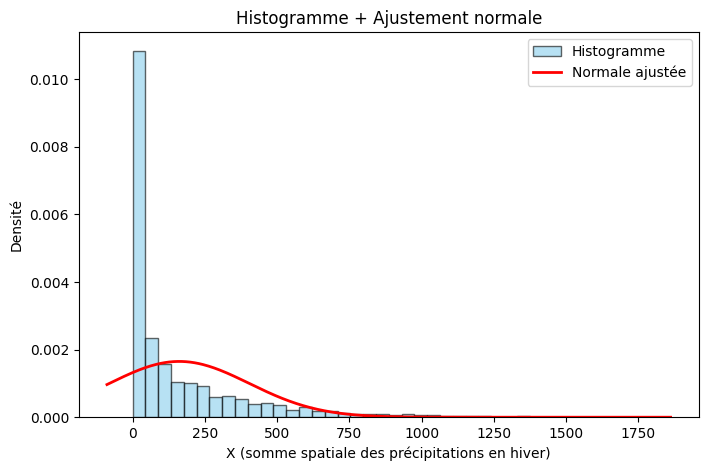

In [29]:
# Ajustement à la loi normale
mu, sigma = norm.fit(X)
print("Paramètres normale :", mu, sigma)

# Histogramme + densité normale ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(X, bins=40, density=True, alpha=0.6, color='skyblue',
         edgecolor='black', label="Histogramme")

# Courbe théorique normale ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=2, label="Normale ajustée")

plt.xlabel("X (somme spatiale des précipitations en hiver)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement normale")
plt.legend()

# Log-vraisemblance
logL = np.sum(norm.logpdf(X, mu, sigma))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 2 paramètres : mu, sigma)
AIC_norm = 2*2 - 2*logL
print("AIC =", AIC_norm)


On fait des tests statistiques: Shapiro-Wilk (spécialement pour Gaussienne) et Kolmogorov-Smirnov pour valider ou non la distribution.

In [30]:
# Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(X)
print("Test Shapiro-Wilk :")
print("  statistique =", shapiro_stat)
print("  p-value     =", shapiro_p, "\n")

# KS (Kolmogorov-Smirnov)
ks_stat, ks_p = kstest(X, 'norm', args=(mu, sigma))
print("Test KS (paramètres estimés) :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)


Test Shapiro-Wilk :
  statistique = 0.6967099930716832
  p-value     = 1.537676680762198e-64 

Test KS (paramètres estimés) :
  statistique = 0.2519277020227536
  p-value     = 7.347249048916318e-221


**Principe du graphique Quantile-Quantile:**
+ *Axe Horizontal - Quantiles Théoriques:*
 Représente les quantiles théoriques de la distribution normale standard (ou de la distribution normale ajustée aux données).

+ *Axe Vertical - Quantiles réels :* Valeurs Ordonnées
 Représente les valeurs observées (ensemble de données), triées par ordre croissant.

Chaque point bleu représente une observation (ordonnée) et le quantile théorique correspondant (abscisse) ((ie) qu'il devrait avoir si les données suivaient parfaitement la loi normale ajustée).

Si les données suivaient parfaitement la loi normale, tous les points devraient se situer exactement sur la droite y=x, car les quantiles théoriques seraient égaux aux quantiles observés.



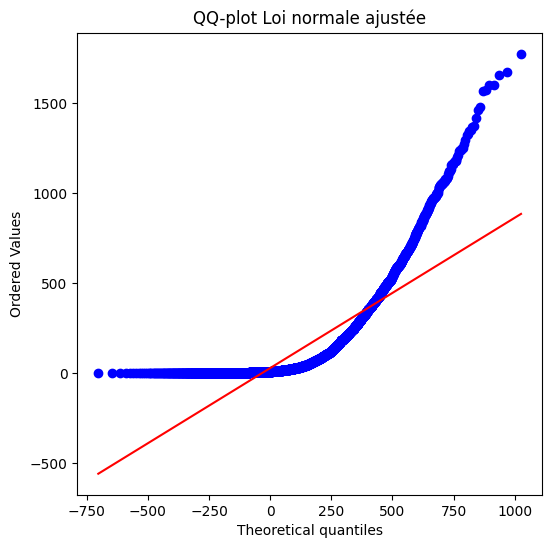

In [31]:
# Diagramme Quantile-Quantile de la normale
plt.figure(figsize=(6,6))
st.probplot(X, dist=norm, sparams=(mu, sigma), plot=plt)
plt.title("QQ-plot Loi normale ajustée")
plt.show()

**Analyse du QQ-Plot de la normale**

Le QQ-plot montre un écart significatif par rapport à l'alignement parfait, indiquant que la distribution des données n'est pas normale :

+ Centre de la Distribution : les points suivent presque la droite, on a donc un comportement quasi-normale au centre.

+ Queue Gauche (Petites Valeurs) : Pas de valeurs négatives dans les précipitations alors que la loi normale centrée en µ (~145mm) en prévoit.

+ Queue Droite (Grandes Valeurs) : Les points bleus s'envolent au-dessus de la ligne rouge. Cela montre qu'il y a des valeurs extrêmes positives. Ces valeurs sont beaucoup plus élevées que ce qu'une distribution normale classique permettrait.

**Conclusion :** La distribution est fortement asymétrique et possède des queues plus épaisses que la distribution normale, ce qui invalide l'hypothèse de normalité pour cet ensemble de données.

### **2. Distribution Gamma**

Paramètres gamma : 0.39928228572364083 413.82065
Log-vraisemblance maximale : -21896.201158893622
AIC = 43796.402317787244


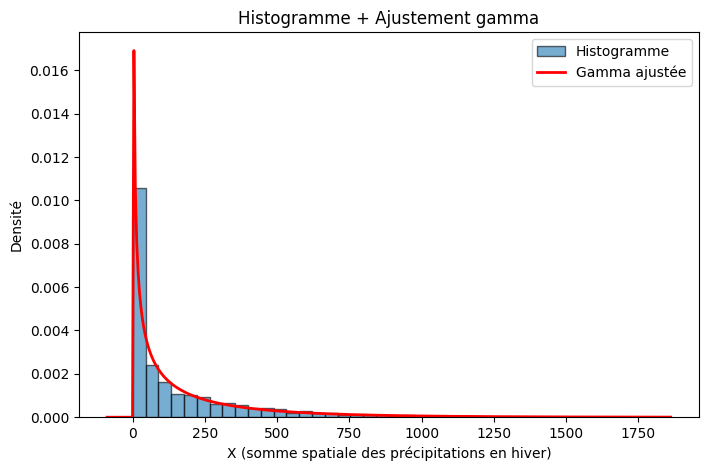

In [32]:
# Garder uniquement les valeurs strictement positives
X_pos = X[X > 0]

# Ajustement à la loi Gamma
alpha, loc, beta = gamma.fit(X_pos, floc=0)        # estimation des paramètres
print("Paramètres gamma :", alpha, beta)

# Histogramme + densité gamma ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(X_pos, bins=40, density=True, alpha=0.6,
         edgecolor='black', label="Histogramme")
# Log-vraisemblance
logL_gamma = np.sum(gamma.logpdf(X_pos, alpha, loc=0, scale=beta))
print("Log-vraisemblance maximale :", logL_gamma)

# AIC (k = 2 paramètres : alpha, beta)
AIC_gamma = 2*2 - 2*logL_gamma
print("AIC =", AIC_gamma)

# Courbe théorique gamma ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, gamma.pdf(xx, alpha, loc=0, scale=beta),
         'r-', lw=2, label="Gamma ajustée")

plt.xlabel("X (somme spatiale des précipitations en hiver)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement gamma")
plt.legend()
plt.show()


Statistique KS : 0.027540671413147866
p-value : 0.005671533589011509


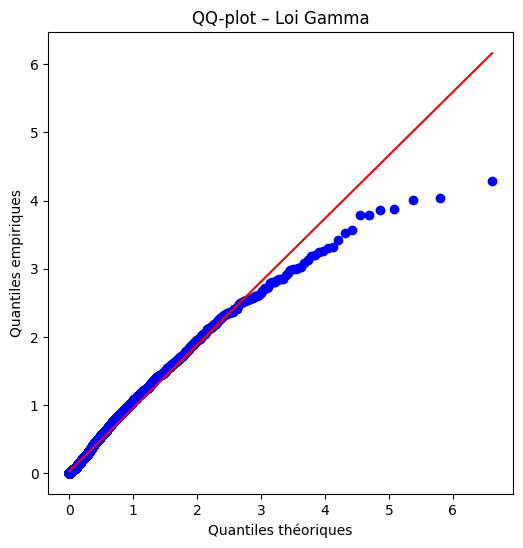

In [33]:
# Test de Kolmogorov–Smirnov pour la loi Gamma ajustée
D, p_value = kstest(X_pos, 'gamma', args=(alpha, 0, beta))

print("Statistique KS :", D)
print("p-value :", p_value)

# Données standardisées (enlever scale)
X_std = X_pos / beta

# QQ-plot Gamma (scale = 1)
plt.figure(figsize=(6,6))
probplot(X_std, dist=gamma, sparams=(alpha,), plot=plt)
plt.title("QQ-plot – Loi Gamma")
plt.xlabel("Quantiles théoriques")
plt.ylabel("Quantiles empiriques")
plt.show()


Le QQ-plot montre un bon alignement des quantiles centraux, indiquant que la loi Gamma décrit correctement la partie principale des données.
En revanche, les écarts marqués dans la queue droite révèlent une sous-estimation des événements extrêmes, fréquente pour les précipitations intenses.

*Optionnel: On peut utiliser le bootstrap pour estimer les paramètres*

**Principe:** On veut estimer α (shape) et β (scale) de la loi Gamma pour les précipitations positives X_pos.
On fait un bootstrap : répéter 1000 fois
- tirer un échantillon aléatoire avec remise depuis X_pos
- ajuster une Gamma sur cet échantillon (gamma.fit)
stocker les paramètres estimés α et β

À la fin, on obtient 1000 valeurs de α et β → permet de mesurer l’incertitude sur ces paramètres.

In [34]:
# Bootstrap pour la loi Gamma: ré-échantillonner X_pos et ré-estimer les paramètres Gamma
# Paramètres
n_boot = 1000
alpha_boot = []
beta_boot = []

# Bootstrap
for _ in range(n_boot):
    Xb = np.random.choice(X_pos, size=len(X_pos), replace=True)  # ré-échantillonnage
    a, loc, b = gamma.fit(Xb, floc=0)                             # ajustement gamma
    alpha_boot.append(a)
    beta_boot.append(b)

alpha_boot = np.array(alpha_boot)
beta_boot = np.array(beta_boot)

In [35]:
# Intervalles de confiance (95 %)
alpha_ci = np.percentile(alpha_boot, [2.5, 97.5])
beta_ci  = np.percentile(beta_boot,  [2.5, 97.5])

print("IC 95% alpha :", alpha_ci)
print("IC 95% beta  :", beta_ci)

IC 95% alpha : [0.38727975 0.41371005]
IC 95% beta  : [389.54618301 436.33240891]


### **3. Distribution Beta**

/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


Paramètres beta : 0.6673451288526319 127.528071203346 -0.0012271106243133547 10927.94421347912
Log-vraisemblance maximale : -24540.88539149897
AIC = 49089.77078299794


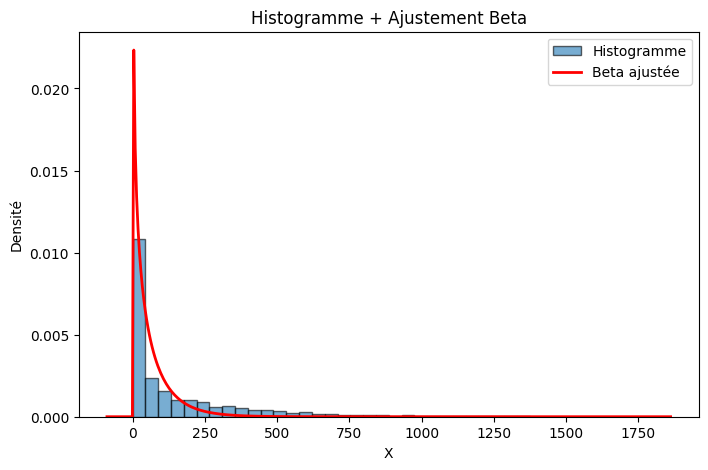

In [36]:
# Ajustement à la loi Beta (avec loc et scale libres)
a, b, loc, scale = beta_dist.fit(X)
print("Paramètres beta :", a, b, loc, scale)

# Histogramme + densité beta ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(X, bins=40, density=True, alpha=0.6,
         edgecolor='black', label="Histogramme")

# Log-vraisemblance
logL_beta = np.sum(beta_dist.logpdf(X, a, b, loc=loc, scale=scale))
print("Log-vraisemblance maximale :", logL_beta)

# AIC (4 paramètres : a, b, loc, scale)
AIC_beta = 2*4 - 2*logL_beta
print("AIC =", AIC_beta)

# Courbe théorique beta ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, beta_dist.pdf(xx, a, b, loc=loc, scale=scale),
         'r-', lw=2, label="Beta ajustée")

plt.xlabel("X")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement Beta")
plt.legend()
plt.show()


Statistique KS : 0.23490034085809985
p-value : 1.0556872155883138e-191


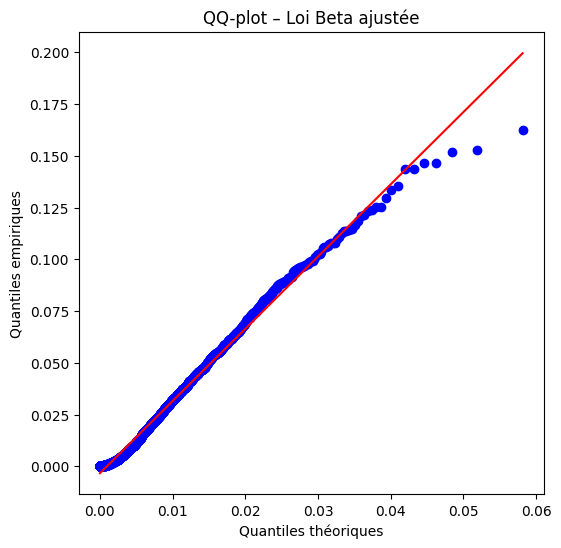

In [37]:
# Test KS pour la loi Beta ajustée
D, p_value = kstest(X, 'beta', args=(a, b, loc, scale))
print("Statistique KS :", D)
print("p-value :", p_value)

# Recentrage / rescaling sur [0,1]
X_std = (X - loc) / scale

# QQ-plot pour la loi Beta
plt.figure(figsize=(6,6))
probplot(X_std, dist=beta_dist, sparams=(a, b), plot=plt)
plt.title("QQ-plot – Loi Beta ajustée")
plt.xlabel("Quantiles théoriques")
plt.ylabel("Quantiles empiriques")
plt.show()

Le QQ-plot montre un bon accord pour les quantiles centraux, ce qui indique que la loi Beta ajustée reproduit correctement la masse principale des données.
Les écarts visibles dans la queue droite traduisent toutefois une mauvaise représentation des valeurs extrêmes, confirmant les limites de ce modèle pour les fortes précipitations.

**On s'intéressera donc, ensuite, aux queues de distribution**

## **Etude des queues de distribution pour les précipitations**

### 1.Définition des variables:

On définit quatre variables :

1) **WinterPI :** la somme des précipitations sur tout l’hiver DJF (Décembre-Janvier-Février) en mm.

2) **Somme_mois :** la somme des précipitations pour chaque mois de l’hiver DJF en mm.

3) **pr_max_an :** la précipitation maximale observée sur un jour de chaque hiver (DJF), en mm.

4) **pr_max_mois :** la valeur maximale de précipitation enregistrée sur un jour pour chaque mois, exprimée en mm.

Toutes les variables sont calculées sur toutes la Bretagne (somme spatiale déjà faite dans X)  

In [38]:
# max par mois, on revient au dataset pour récuperer les mois et trouver les max
# Créer un DataArray 'year_month' correspondant à chaque date
year_month = xr.DataArray(
    ds_djf['time'].dt.year * 100 + ds_djf['time'].dt.month,  # format YYYYMM
    coords={'time': ds_djf['time']},
    dims='time'
)

# Maximum journalier par mois (somme spatiale)
pr_journalier = ds_djf['pr'].sum(dim=['Latitude', 'Longitude'])
pr_max_mois = pr_journalier.groupby(year_month).max() # c'est X en fait

print(pr_max_mois)
print("Nombre de mois :", len(pr_max_mois))

<xarray.DataArray 'pr' (group: 131)> Size: 1kB
array([1058.59155273,  577.61437988,  602.65148926,  316.55535889,
        859.3081665 , 1181.05480957,  791.54852295,  690.95629883,
        937.91412354,  476.14718628,  577.16583252,  817.96636963,
        748.51074219,  484.96334839, 1045.43225098,  697.70648193,
        879.05725098,  484.90875244,  858.49359131,  733.7923584 ,
        546.23248291,  646.79193115,  411.69680786,  552.69018555,
       1153.6151123 , 1599.95825195,  479.11520386,  313.20407104,
        638.47875977, 1656.36572266, 1326.03198242, 1159.55566406,
       1051.9831543 , 1160.58227539,  465.8762207 ,  264.6133728 ,
        342.52130127,  353.67645264, 1231.94140625, 1601.25073242,
        391.15319824,  596.69836426,  801.44671631,  913.79528809,
       1159.37939453, 1773.33312988,  586.9230957 , 1122.1940918 ,
        718.67749023,  994.18597412,  882.56054688,  240.35169983,
       1068.23120117,  591.1887207 ,  832.15924072,  565.8873291 ,
        981.617

In [39]:
# Somme journalière spatiale
somme_quotidienne_pr_djf = ds_djf['pr'].sum(dim=['Latitude', 'Longitude']) # c'est X en fait

# Somme totale par hiver
# on définit l'hiver en comptant: décembre de l'année i-1 et janvier, février de l'année i
annee_hiver = ds_djf['time.year'].where(ds_djf['time.month'] != 12, ds_djf['time.year'] + 1)
WinterPI = ds_djf['pr'].groupby(annee_hiver).sum(dim=['time', 'Latitude', 'Longitude'])
WinterPI = WinterPI.assign_coords(year=np.unique(annee_hiver.values))

# Somme mensuelle
Somme_mois = (
    ds_djf['pr']
    .sum(dim=['Latitude', 'Longitude'])  # somme spatiale
    .groupby(year_month)
    .sum(dim='time')                     # somme TEMPORELLE
)

# maximum par an
pr_max_an = ds_djf['pr'].sum(dim=['Latitude','Longitude']).groupby('time.year').max()

# Affichage final
print(annee_hiver)
print("WinterPI (somme d'un hiver DJF)", WinterPI)
print("Nombre d'hivers :", len(WinterPI))

print("Somme par mois (DJF)", Somme_mois)
print("Nombre de mois :", len(Somme_mois))

print("Max par mois (précipitation journalière max)",pr_max_an )
print("Nombre d'année :", len(pr_max_an))
pr_max_an.shape


<xarray.DataArray 'year' (time: 3940)> Size: 32kB
array([1980, 1980, 1980, ..., 2023, 2023, 2023])
Coordinates:
  * time     (time) datetime64[ns] 32kB 1980-01-01 1980-01-02 ... 2023-02-28
    height   float64 8B 0.0
WinterPI (somme d'un hiver DJF) <xarray.DataArray 'pr' (year: 44)> Size: 176B
array([ 7981.08  ,  9715.227 , 18556.426 , 13831.113 , 15407.055 ,
       14046.289 , 16734.344 ,  9234.358 , 20176.715 ,  7646.9746,
       24017.86  , 12432.268 ,  3969.125 , 11236.785 , 18439.773 ,
       24608.36  , 14611.942 , 10769.965 , 12307.036 , 14642.007 ,
       16343.527 , 23885.414 , 11435.121 , 16348.952 , 15704.693 ,
        6946.047 ,  9393.963 , 18730.018 , 13448.701 , 12046.453 ,
       16177.433 , 12003.803 , 11839.53  , 17250.113 , 26754.2   ,
       12863.21  , 17557.328 ,  8779.951 , 15789.298 , 12778.248 ,
       17878.33  , 18529.428 , 10474.743 , 13478.042 ], dtype=float32)
Coordinates:
  * year     (year) int64 352B 1980 1981 1982 1983 1984 ... 2020 2021 2022 2023
    h

(44,)

In [40]:
print(len(Somme_mois)) #vérification en regardant le nombre de mois pris en compte (normalement: 84*3-1=251)
print(len(Somme_mois))
np.unique(year_month)[:252]
np.unique(year_month)[-252:]

131
131


array([198001, 198002, 198012, 198101, 198102, 198112, 198201, 198202,
       198212, 198301, 198302, 198312, 198401, 198402, 198412, 198501,
       198502, 198512, 198601, 198602, 198612, 198701, 198702, 198712,
       198801, 198802, 198812, 198901, 198902, 198912, 199001, 199002,
       199012, 199101, 199102, 199112, 199201, 199202, 199212, 199301,
       199302, 199312, 199401, 199402, 199412, 199501, 199502, 199512,
       199601, 199602, 199612, 199701, 199702, 199712, 199801, 199802,
       199812, 199901, 199902, 199912, 200001, 200002, 200012, 200101,
       200102, 200112, 200201, 200202, 200212, 200301, 200302, 200312,
       200401, 200402, 200412, 200501, 200502, 200512, 200601, 200602,
       200612, 200701, 200702, 200712, 200801, 200802, 200812, 200901,
       200902, 200912, 201001, 201002, 201012, 201101, 201102, 201112,
       201201, 201202, 201212, 201301, 201302, 201312, 201401, 201402,
       201412, 201501, 201502, 201512, 201601, 201602, 201612, 201701,
      

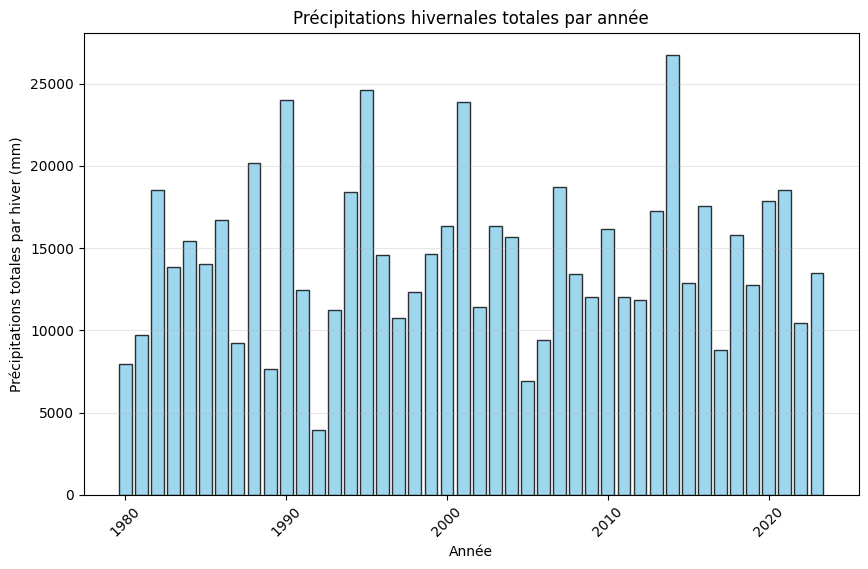

In [41]:
# Histogramme des précipitations par hiver pour chaque année
plt.figure(figsize=(10,6))
plt.bar(WinterPI.year, WinterPI.values, color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel("Année")
plt.ylabel("Précipitations totales par hiver (mm)")
plt.title("Précipitations hivernales totales par année")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

### 2.GEV sur les maximums hivernaux de précipitation

On trace d'abord l'histogramme des maximums hivernaux et l'ajustement normal

mu: 1160.6660489169035 sigma: 272.1828122053312


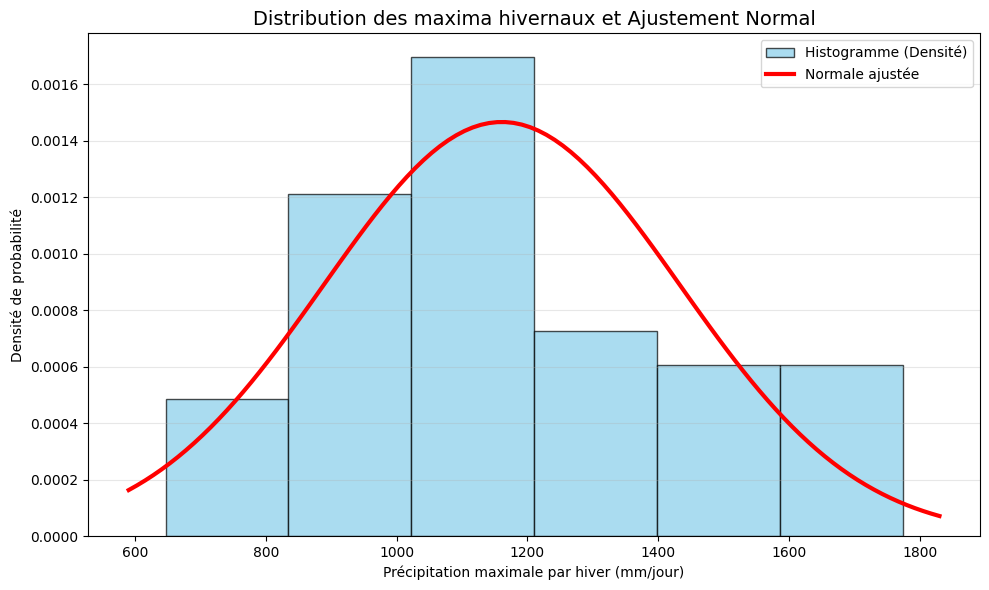

In [42]:
# Tracé de l'histogramme en densité
plt.figure(figsize=(10,6))
# Calculer le nombre de bins (sqrt(N) ici) pour le pas de l'histogramme
bins = int(np.sqrt(len(pr_max_an.values)))

plt.hist(pr_max_an.values, bins=bins, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Histogramme (Densité)')

# Courbe normale ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 100)

mu, sigma = norm.fit(pr_max_an.values)
plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=3,
         label=f'Normale ajustée')
print("mu:", mu, "sigma:", sigma)

# Labels et légende
plt.xlabel("Précipitation maximale par hiver (mm/jour)")
plt.ylabel("Densité de probabilité")
plt.title("Distribution des maxima hivernaux et Ajustement Normal", fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

On trace ensuite la GEV sur les max hivernaux (on définit les paramètres c1, loc1, scale1)

Paramètres GEV ajustés :
 c (shape) = -5.709, loc1 = 647.10, scale1 = 1.73


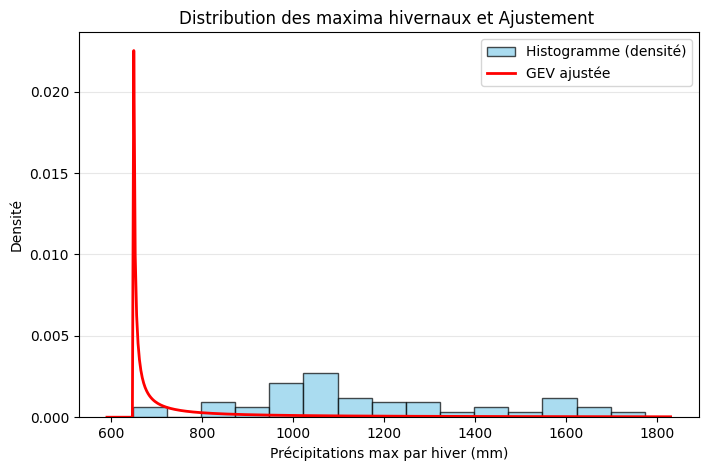

In [43]:
# Ajustement GEV
# genextreme utilise un paramètre c1 (shape), loc1 (location), scale1 (scale)
c1, loc1, scale1 = genextreme.fit(pr_max_an.values)
print(f"Paramètres GEV ajustés :\n c (shape) = {c1:.3f}, loc1 = {loc1:.2f}, scale1 = {scale1:.2f}")

# Histogramme en densité
plt.figure(figsize=(8,5))
plt.hist(pr_max_an.values, bins=15, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogramme (densité)')

# Courbe GEV ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genextreme.pdf(xx, c1, loc1, scale1), 'r-', lw=2, label='GEV ajustée')

# Labels et légende
plt.xlabel("Précipitations max par hiver (mm)")
plt.ylabel("Densité")
plt.title("Distribution des maxima hivernaux et Ajustement ")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()



**Lien avec le cours:**

ξ=c (paramètre de forme ou shape)

μ=loc (paramètre de position ou location)

σ=scale (paramètre d'échelle ou scale)

On calcule l'AIC et la p-value pour cette distribution.

In [44]:
# Construction de la CDF paramétrée
gev_cdf = lambda x: genextreme(c1, loc1, scale1).cdf(x)

# KS-test
ks_stat, ks_p = kstest(WinterPI.values, gev_cdf)

print("Test KS (GEV ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genextreme.logpdf(WinterPI.values, c1, loc1, scale1))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 2 paramètres)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)



Test KS (GEV ajustée) :
  Statistique = 0.8219406831354257
  p-value     = 3.527599222312239e-33
Log-vraisemblance maximale : -582.131287571334
AIC = 1170.262575142668


**Raisons du Mauvais Ajustement**

On a trop peu de valeurs

### 3.GEV sur les maximums mensuels de précipitation

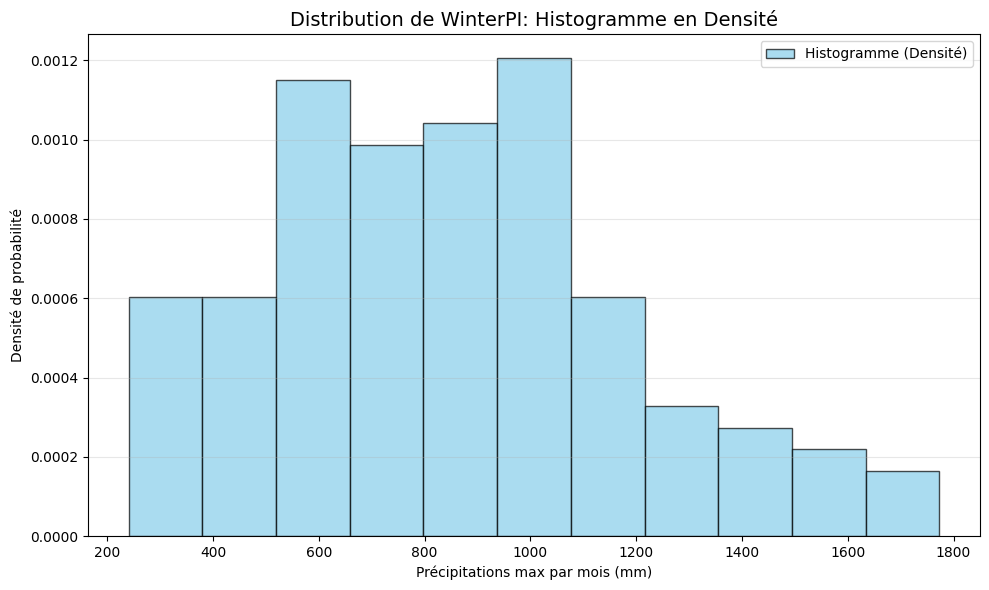

In [45]:
# Tracé de l'histogramme en densité
plt.figure(figsize=(10,6))
# Calculer le nombre de bins (souvent sqrt(N) ou formule de Freedman-Diaconis)
bins = int(np.sqrt(len(pr_max_mois)))

plt.hist(pr_max_mois, bins=bins, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Histogramme (Densité)')

# Labels et légende
plt.xlabel("Précipitations max par mois (mm)")
plt.ylabel("Densité de probabilité")
plt.title("Distribution de WinterPI: Histogramme en Densité", fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Paramètres GEV ajustés :
 c (shape) = 0.134, loc2 = 707.81, scale2 = 305.63


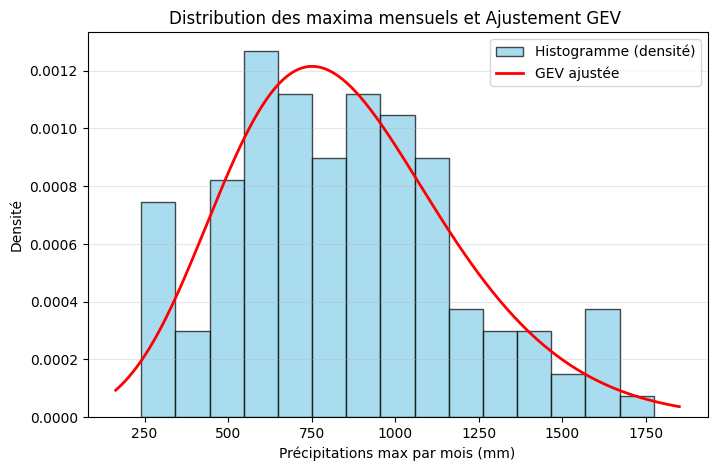

In [46]:
# Ajustement GEV
# genextreme utilise un paramètre c2 (shape), loc2 (location), scale2 (scale)
c2, loc2, scale2 = genextreme.fit(pr_max_mois)
print(f"Paramètres GEV ajustés :\n c (shape) = {c2:.3f}, loc2 = {loc2:.2f}, scale2 = {scale2:.2f}")

# Histogramme en densité
plt.figure(figsize=(8,5))
plt.hist(pr_max_mois.values, bins=15, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogramme (densité)')

# Courbe GEV ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genextreme.pdf(xx, c2, loc2, scale2), 'r-', lw=2, label='GEV ajustée')

# Labels et légende
plt.xlabel("Précipitations max par mois (mm)")
plt.ylabel("Densité")
plt.title("Distribution des maxima mensuels et Ajustement GEV ")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


In [47]:
# Construction de la CDF paramétrée
gev_cdf = lambda x: genextreme(c2, loc2, scale2).cdf(x)

# KS-test
ks_stat, ks_p = kstest(pr_max_mois, gev_cdf)

print("Test KS (GEV ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

Test KS (GEV ajustée) :
  Statistique = 0.03329570278515684
  p-value     = 0.9977175895379831


### 4.GPD sur le cumul hivernal de précipitation

nombre de valeurs prises en compte : 13


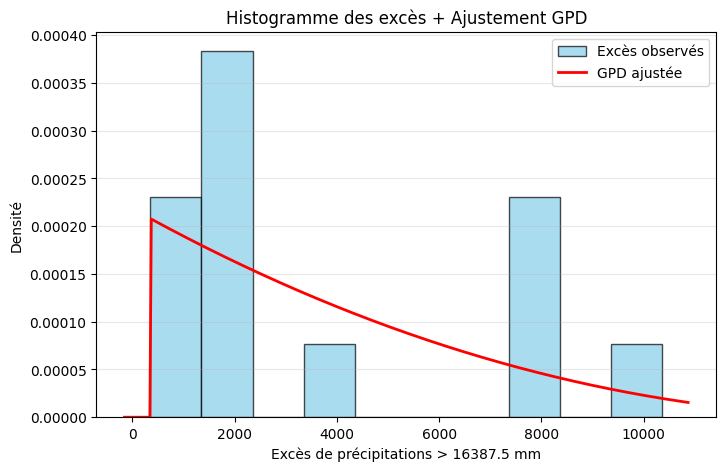

Paramètres GPD : shape(c)=-0.329, loc3=346.9, scale3=4804.8


In [48]:

# 1. Choisir un seuil pour les extrêmes
seuil = np.percentile(WinterPI.values, threshold)  # 70ème percentile
exceedances_W = WinterPI.values[WinterPI.values > seuil] - seuil  # excès au-dessus du seuil
print("nombre de valeurs prises en compte :", len(exceedances_W))
# 2. Ajuster la GPD aux excès
c3, loc3, scale3 = genpareto.fit(exceedances_W)

# 3. Histogramme des excès (densité)
plt.figure(figsize=(8,5))
plt.hist(exceedances_W, bins=10, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Excès observés')

# 4. Courbe GPD ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genpareto.pdf(xx, c3, loc3, scale3), 'r-', lw=2, label='GPD ajustée')

# 5. Labels et légende
plt.xlabel(f"Excès de précipitations > {seuil:.1f} mm")
plt.ylabel("Densité")
plt.title("Histogramme des excès + Ajustement GPD")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# 6. Affichage des paramètres
print(f"Paramètres GPD : shape(c)={c3:.3f}, loc3={loc3:.1f}, scale3={scale3:.1f}")


In [49]:
# Construction de la  paramétrée
gpd_cdf = lambda x: genpareto(c3, loc3, scale3).cdf(x)

# KS-test
ks_stat, ks_p = kstest(exceedances_W, gpd_cdf)

print("Test KS (GPD ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genpareto.logpdf(exceedances_W, c3, loc3, scale3))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 3)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)

Test KS (GPD ajustée) :
  Statistique = 0.25517490191241593
  p-value     = 0.31039702973764316
Log-vraisemblance maximale : -118.92777951341976
AIC = 243.85555902683953


**Remarque**: on a peu de valeurs pourtant on a pris un seuil bas, donc on passe au cumul par mois

### 5.GPD sur le cumul mensuel de précipitation

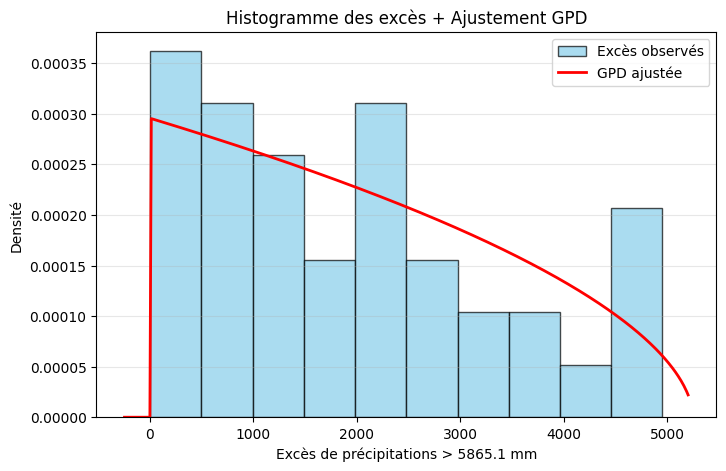

Paramètres GPD : shape(c)=-0.645, loc4=1.6, scale4=3382.8


In [50]:
# 1. Choisir un seuil pour les extrêmes
seuil = np.percentile(Somme_mois, threshold)  # 70ème percentile
exceedances_M = Somme_mois[Somme_mois > seuil] - seuil  # excès au-dessus du seuil

# 2. Ajuster la GPD aux excès
c4, loc4, scale4 = genpareto.fit(exceedances_M)

# 3. Histogramme des excès (densité)
plt.figure(figsize=(8,5))
plt.hist(exceedances_M, bins=10, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Excès observés')

# 4. Courbe GPD ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genpareto.pdf(xx, c4, loc4, scale4), 'r-', lw=2, label='GPD ajustée')

# 5. Labels et légende
plt.xlabel(f"Excès de précipitations > {seuil:.1f} mm")
plt.ylabel("Densité")
plt.title("Histogramme des excès + Ajustement GPD")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# 6. Affichage des paramètres
print(f"Paramètres GPD : shape(c)={c4:.3f}, loc4={loc4:.1f}, scale4={scale4:.1f}")

In [51]:
# Construction de la  paramétrée
gpd_cdf = lambda x: genpareto(c4, loc4, scale4).cdf(x)

# KS-test
ks_stat, ks_p = kstest(exceedances_M, gpd_cdf)

print("Test KS (GPD ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genpareto.logpdf(exceedances_M, c4, loc4, scale4))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 3)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)

Test KS (GPD ajustée) :
  Statistique = 0.11469080965398548
  p-value     = 0.6422540560473444
Log-vraisemblance maximale : -330.79465204952396
AIC = 667.5893040990479


Les valeurs sont satisfaisantes

### 6.GPD sur le cumul journalier de précipitation

Ici on traite X.

In [52]:
print("len(X) =", len(X))
print("min(X), max(X) =", np.nanmin(X), np.nanmax(X))

seuil = np.nanpercentile(X, threshold)
print("seuil =", seuil)

print("nb X > seuil =", np.sum(X > seuil))

len(X) = 3940
min(X), max(X) = -0.0012271106 1773.3331
seuil = 175.38098
nb X > seuil = <xarray.DataArray 'pr' ()> Size: 8B
array(1182)
Coordinates:
    height   float64 8B 0.0


Avec un seuil à 70%, on conserve 2265 jours.

Nombre d'excès : 394


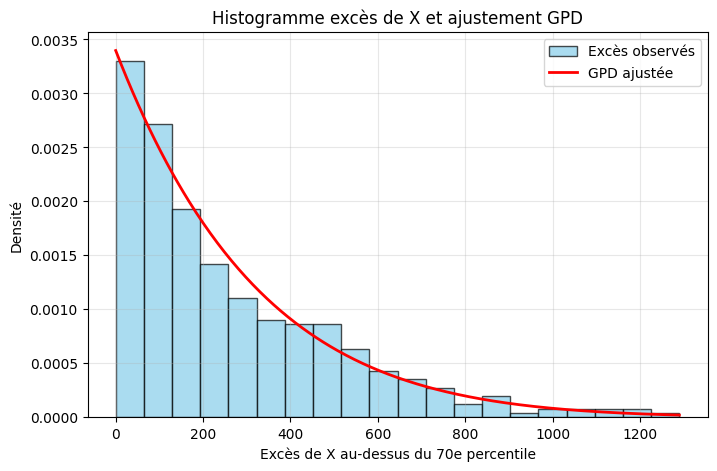

Paramètres GPD : shape=-0.096, scale=294.339


In [126]:
X_np = X.values

# Seuil
seuil = np.percentile(X_np, 90)

# Excès
exceedances_D = X_np[X_np > seuil] - seuil
print("Nombre d'excès :", len(exceedances_D))

# Ajustement GPD
c4, loc4, scale4 = genpareto.fit(exceedances_D, floc=0)

# Histogramme
plt.figure(figsize=(8,5))
plt.hist(exceedances_D, bins=20, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Excès observés')

# Courbe GPD
xx = np.linspace(0, exceedances_D.max(), 400)
plt.plot(xx, genpareto.pdf(xx, c4, loc=0, scale=scale4),
         'r-', lw=2, label='GPD ajustée')

plt.xlabel("Excès de X au-dessus du 70e percentile")
plt.ylabel("Densité")
plt.title("Histogramme excès de X et ajustement GPD")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Paramètres GPD : shape={c4:.3f}, scale={scale4:.3f}")


In [54]:
# Construction de la  paramétrée
gpd_cdf = lambda x: genpareto(c4, loc4, scale4).cdf(x)

# KS-test
ks_stat, ks_p = kstest(exceedances_D, gpd_cdf)

print("Test KS (GPD ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genpareto.logpdf(exceedances_D, c4, loc4, scale4))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 3)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)

Test KS (GPD ajustée) :
  Statistique = 0.021576928254943506
  p-value     = 0.6328844264082851
Log-vraisemblance maximale : -7819.242624674098
AIC = 15644.485249348196


## **Etude des vents (Y)**

### **1. Distribution normale**

Paramètres normale : 6.5599313 2.499209
Log-vraisemblance maximale : -9199.556587442248
AIC = 18403.113174884496
Test Shapiro-Wilk :
  statistique = 0.9685887973392293
  p-value     = 1.5713418846260235e-28 

Test KS :
  statistique = 0.05693260191949823
  p-value     = 1.529579707778854e-11


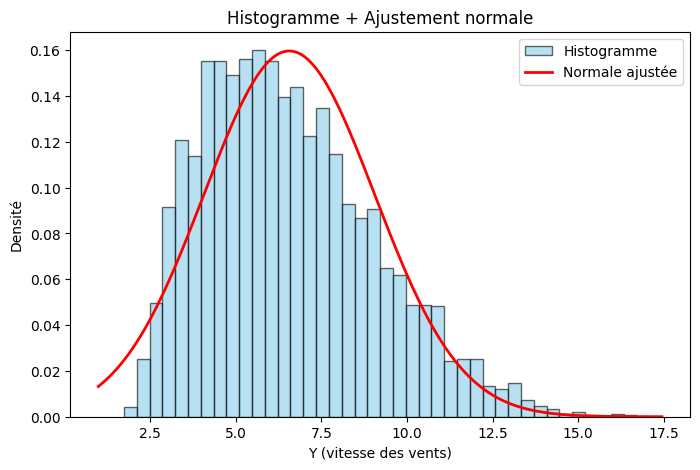

In [55]:
# Pour Y
# Ajustement à la loi normale
mu, sigma = norm.fit(Y)
print("Paramètres normale :", mu, sigma)

# Histogramme + densité normale ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(Y, bins=40, density=True, alpha=0.6, color='skyblue',
         edgecolor='black', label="Histogramme")

# Courbe théorique normale ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=2, label="Normale ajustée")

plt.xlabel("Y (vitesse des vents)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement normale")
plt.legend()

# Log-vraisemblance
logL = np.sum(norm.logpdf(Y, mu, sigma))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 2 paramètres : mu, sigma)
AIC_norm = 2*2 - 2*logL
print("AIC =", AIC_norm)

# ------ Shapiro-Wilk ------
shapiro_stat, shapiro_p = shapiro(Y)
print("Test Shapiro-Wilk :")
print("  statistique =", shapiro_stat)
print("  p-value     =", shapiro_p, "\n")

# ------ KS (Kolmogorov-Smirnov) ------
ks_stat, ks_p = kstest(Y, 'norm', args=(mu, sigma))
print("Test KS :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)


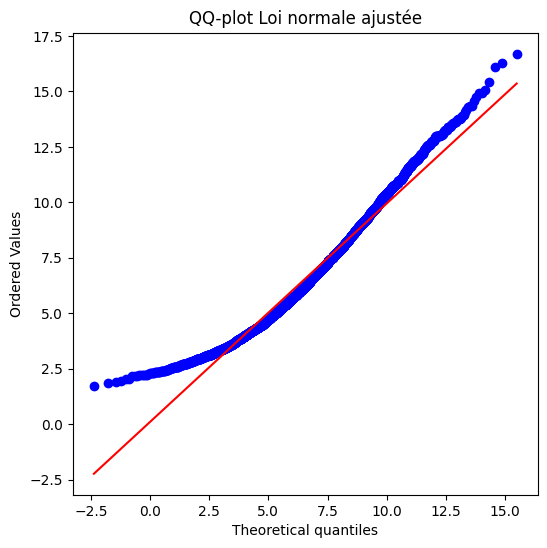

In [56]:
# Diagramme Quantile-Quantile de la noramle
plt.figure(figsize=(6,6))
st.probplot(Y, dist=norm, sparams=(mu, sigma), plot=plt)
plt.title("QQ-plot Loi normale ajustée")
plt.show()

Le QQ-plot montre un écart systématique à la droite, indiquant que la loi normale ne décrit pas correctement la distribution des vitesses de vent.
Les déviations marquées aux extrémités révèlent une asymétrie et des queues mal représentées par le modèle normal.

### **2. Distribution Gamma**

Paramètres gamma : 6.903244743946573 413.82065
Log-vraisemblance maximale : -147133.96563980647
AIC = 294271.93127961294
Test KS :
  statistique = 0.9999999999999446
  p-value     = 0.0


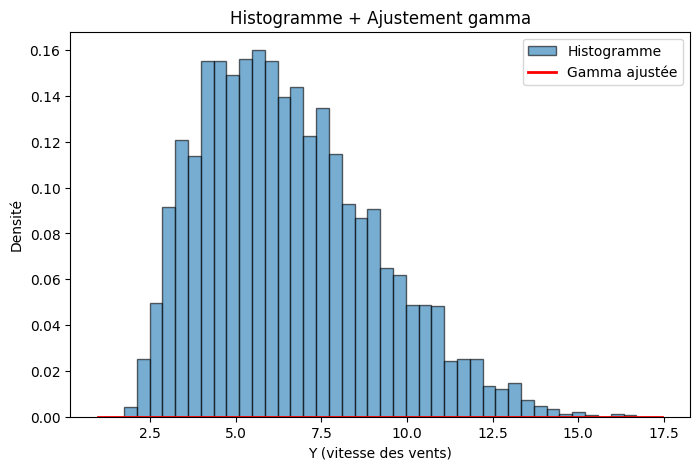

In [57]:
Y_pos = Y[Y > 0]

# Ajustement à la loi Gamma
alpha, loc, scale_gamma = gamma.fit(Y_pos, floc=0)
print("Paramètres gamma :", alpha, beta)

# Histogramme + densité gamma ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(Y_pos, bins=40, density=True, alpha=0.6,
         edgecolor='black', label="Histogramme")

# Log-vraisemblance
logL_gamma = np.sum(gamma.logpdf(Y_pos, alpha, loc=0, scale=beta))
print("Log-vraisemblance maximale :", logL_gamma)

# AIC (k = 2 paramètres : alpha, beta)
AIC_gamma = 2*2 - 2*logL_gamma
print("AIC =", AIC_gamma)

# KS (Kolmogorov-Smirnov)
ks_stat, ks_p = kstest(Y_pos, 'gamma', args=(alpha, 0, beta))
print("Test KS :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)

# Courbe théorique gamma ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, gamma.pdf(xx, alpha, loc=0, scale=beta),
         'r-', lw=2, label="Gamma ajustée")

plt.xlabel("Y (vitesse des vents)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement gamma")
plt.legend()
plt.show()

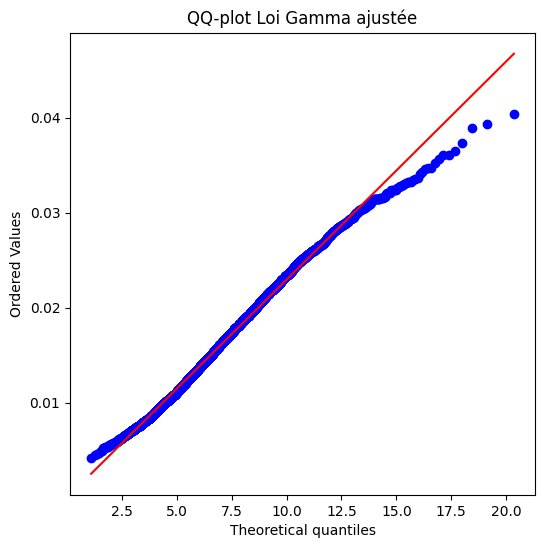

In [58]:
# Diagramme Quantile-Quantile de la loi Gamma
plt.figure(figsize=(6,6))

# Données standardisées (enlever scale)
Y_std = Y_pos / beta

st.probplot(Y_std, dist=gamma, sparams=(alpha,), plot=plt)

plt.title("QQ-plot Loi Gamma ajustée")
plt.show()

Le QQ-plot montre un bon alignement des quantiles centraux, indiquant que la loi Gamma décrit correctement la distribution des vitesses de vent.
Les écarts observés dans la queue droite suggèrent toutefois une légère sous-estimation des valeurs de vent les plus élevées.

### **3. Distribution Beta**

Paramètres beta : 2.6393998347851153 7.9573847125088495 1.6852283613119432 19.5779978326783
Log-vraisemblance maximale : -8955.967097007746
AIC = 17919.93419401549
Test KS :
  statistique = 0.012677867940851795
  p-value     = 0.5467125406817746


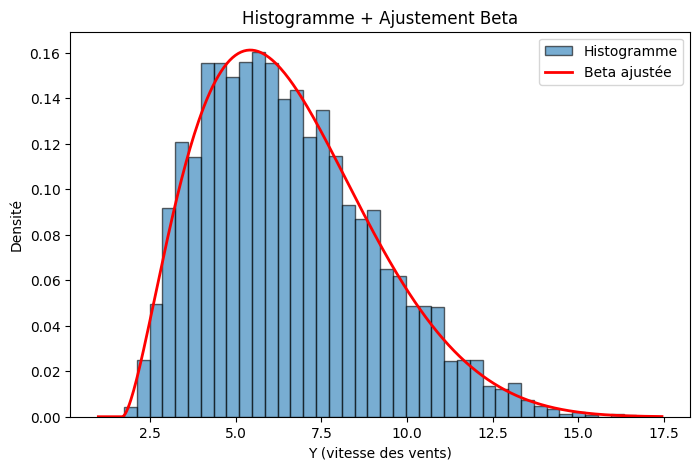

In [59]:
# Ajustement à la loi Beta
a, b, loc, scale = beta_dist.fit(Y)
print("Paramètres beta :", a, b, loc, scale)

# Histogramme + densité beta ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(Y, bins=40, density=True, alpha=0.6,
         edgecolor='black', label="Histogramme")

# Log-vraisemblance (UTILISER beta_dist, pas beta)
logL_beta = np.sum(beta_dist.logpdf(Y, a, b, loc=loc, scale=scale))
print("Log-vraisemblance maximale :", logL_beta)

# AIC : 4 paramètres (a, b, loc, scale)
AIC_beta = 2*4 - 2*logL_beta
print("AIC =", AIC_beta)

# KS (Kolmogorov–Smirnov)
ks_stat, ks_p = kstest(Y, 'beta', args=(a, b, loc, scale))
print("Test KS :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)

# Courbe théorique beta ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, beta_dist.pdf(xx, a, b, loc=loc, scale=scale),
         'r-', lw=2, label="Beta ajustée")

plt.xlabel("Y (vitesse des vents)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement Beta")
plt.legend()
plt.show()


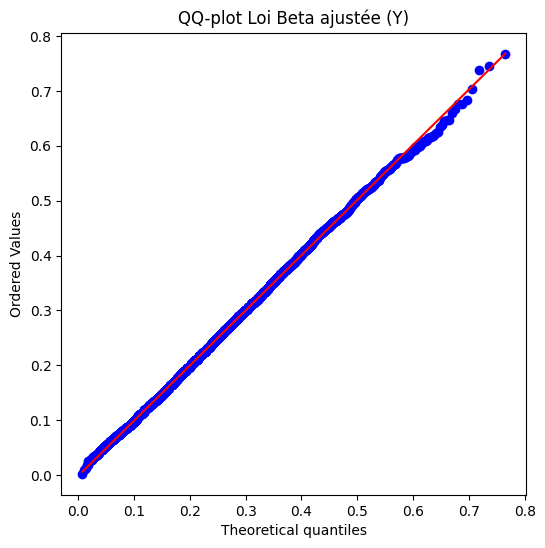

In [60]:
# Recentrer / re-scaler Y pour revenir sur [0,1]
Y_std = (Y - loc) / scale

# QQ-plot Beta avec probplot
plt.figure(figsize=(6,6))
st.probplot(Y_std, dist=beta_dist, sparams=(a, b), plot=plt)
plt.title("QQ-plot Loi Beta ajustée (Y)")
plt.show()

Le QQ-plot montre un très bon alignement sur l’ensemble des quantiles, indiquant que la loi Beta ajustée décrit bien la distribution des vitesses de vent.
Les légers écarts en queue droite restent faibles et suggèrent un ajustement globalement satisfaisant, meilleur que celui de la loi normale.

### **4. GPD pour Y: moyenne de vent journalière**

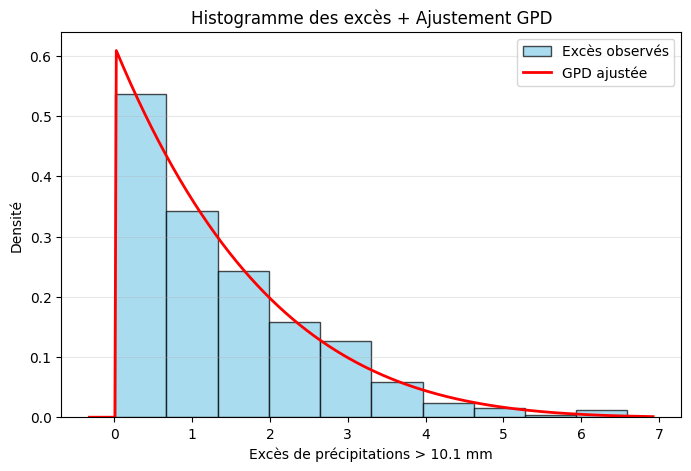

Paramètres GPD : shape(c)=-0.175, loc5=1.7, scale5=1.6


In [128]:
# 1. Choisir un seuil pour les extrêmes
seuil = np.percentile(Y, threshold)  # 70ème percentile
exceedances_YD = Y[Y > seuil] - seuil  # excès au-dessus du seuil

# 2. Ajuster la GPD aux excès
c5, loc5, scale5 = genpareto.fit(exceedances_YD)

# 3. Histogramme des excès (densité)
plt.figure(figsize=(8,5))
plt.hist(exceedances_YD, bins=10, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Excès observés')

# 4. Courbe GPD ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genpareto.pdf(xx, c5, loc5, scale5), 'r-', lw=2, label='GPD ajustée')

# 5. Labels et légende
plt.xlabel(f"Excès de précipitations > {seuil:.1f} mm")
plt.ylabel("Densité")
plt.title("Histogramme des excès + Ajustement GPD")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# 6. Affichage des paramètres
print(f"Paramètres GPD : shape(c)={c5:.3f}, loc5={loc:.1f}, scale5={scale5:.1f}")

In [62]:
# Construction de la  paramétrée
gpd_cdf = lambda x: genpareto(c5, loc5, scale5).cdf(x)

# KS-test
ks_stat, ks_p = kstest(exceedances_YD, gpd_cdf)

print("Test KS (GPD ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genpareto.logpdf(exceedances_YD, c5, loc5, scale5))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 3)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)

Test KS (GPD ajustée) :
  Statistique = 0.02086221649792519
  p-value     = 0.6743195450215475
Log-vraisemblance maximale : -1945.5762613973795
AIC = 3897.152522794759


## **Etude des queues de distribution pour les vents**

### 1.Définition des variables:

In [63]:
# Grouper par année et par mois
Y_max = Y.groupby('time.year').map(lambda x: x.groupby('time.month').max(dim='time'))
print(Y_max.sizes)
print(Y_max.sizes)
print(Y_max.shape)
print(len(Y_max['year']))
print(len(Y_max['month']))

# Transformer en numpy array (shape = nb_annees × 3)
Y_max_values = np.array([x.values for x in Y_max])
print("Shape avant flatten :", Y_max_values.shape)

# Identifiant année–mois réel
year_month = Y['time'].dt.year * 100 + Y['time'].dt.month

# Max mensuel du vent (DJF)
Y_max_month = (
    Y
    .groupby(year_month)
    .max(dim='time')
)

print("La taille de Y_max_month est: ", len(Y_max_month))  # = 251 (comme Somme_mois)

# Affichage
print(Y_max_month)
print(len(Y_max_month))


Frozen({'year': 44, 'month': 3})
Frozen({'year': 44, 'month': 3})
(44, 3)
44
3
Shape avant flatten : (44, 3)
La taille de Y_max_month est:  131
<xarray.DataArray 'sfcWind' (group: 131)> Size: 1kB
array([13.11254311, 11.90599442, 10.97473907, 11.29779053,  9.66340637,
       11.88031864, 11.61692905,  9.48196983, 12.5651474 , 10.85029316,
       12.13713264, 12.60569382, 12.58152103, 11.95260811,  8.53094387,
        9.74221516,  8.3215723 , 10.74817085, 11.38308907,  8.33265686,
       11.55121422,  9.47569847,  8.49543953,  8.70505428, 12.72734642,
       13.41805363, 11.3821249 ,  8.41928768, 11.90913963, 13.93280411,
       16.12527657, 16.29636192, 12.83845425, 13.58676243,  9.55940056,
       10.46180725,  8.75240612,  9.86448383, 13.38666725, 14.59146309,
        9.25338364, 12.39360714, 11.87981892, 10.72318554, 12.44963264,
       14.93804836, 11.2402935 , 10.34495068, 10.61364651, 13.0400486 ,
       10.35977745,  7.83932209, 12.53000164, 11.82381439, 13.74532127,
        7.55

In [64]:
# Création d’un identifiant année–mois (YYYYMM) pour chaque date
year_month = xr.DataArray(
    ds_djf['time'].dt.year * 100 + ds_djf['time'].dt.month,
    coords={'time': ds_djf['time']},
    dims='time'
)

# Regroupement des moyenness de vitesse de vent par mois (année–mois)
Y_moy_mois = Y.groupby(year_month)

print(Y_moy_mois)        # affiche l’objet groupby
print(len(Y_moy_mois))   # nombre de mois DJF distincts


<DataArrayGroupBy, grouped over 1 grouper(s), 131 groups in total:
    'group': UniqueGrouper('group'), 131/131 groups with labels 198001, 198002, ..., 202302>
131


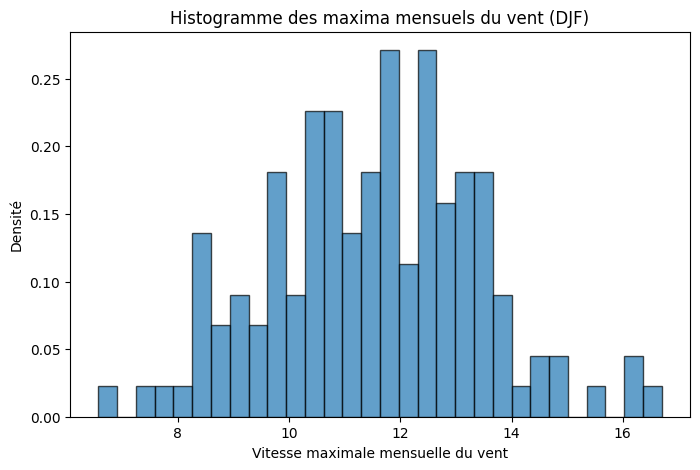

In [65]:
# Histogramme des maxima mensuels du vent (DJF)
plt.figure(figsize=(8,5))

plt.hist(Y_max_month, bins=30, density=True,
         edgecolor='black', alpha=0.7)

plt.xlabel("Vitesse maximale mensuelle du vent")
plt.ylabel("Densité")
plt.title("Histogramme des maxima mensuels du vent (DJF)")
plt.show()


### 2.Normale max mensuel

Test Shapiro-Wilk :
  statistique = 0.9939754670129161
  p-value     = 0.858611044501547 

Test KS (paramètres estimés) :
  statistique = 0.03913210226827296
  p-value     = 0.9841053121965165


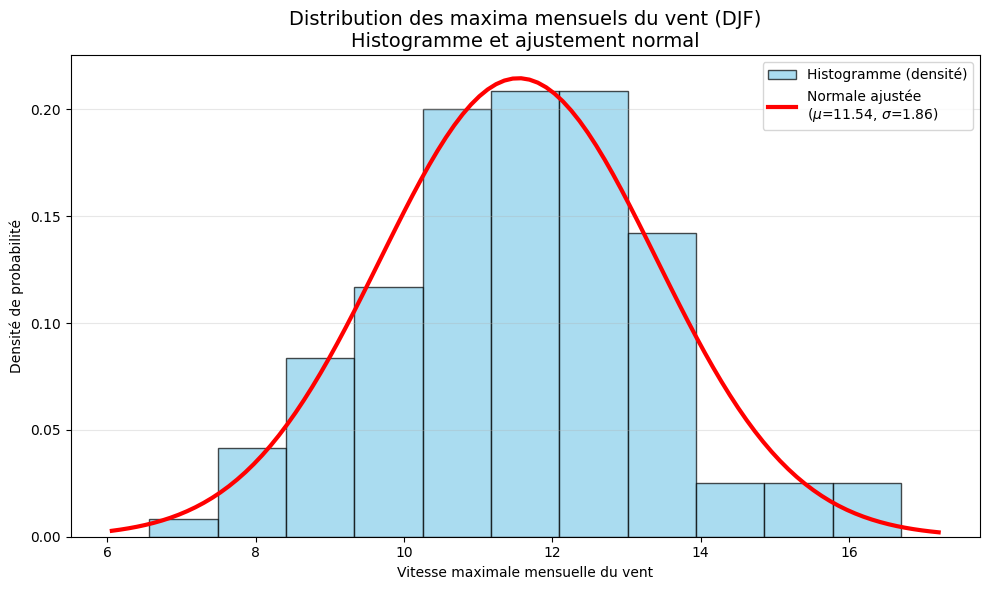

In [66]:
# Tracé de l'histogramme en densité des maxima mensuels du vent
plt.figure(figsize=(10,6))

# Nombre de bins
bins = int(np.sqrt(len(Y_max_month[:-1])))

plt.hist(Y_max_month[:-1], bins=bins, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Histogramme (densité)')

# Ajustement à la loi normale
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 100)
mu, sigma = norm.fit(Y_max_month[:-1])

plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=3,
         label=f'Normale ajustée\n($\\mu$={mu:.2f}, $\\sigma$={sigma:.2f})')

# Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(Y_max_month[:-1])
print("Test Shapiro-Wilk :")
print("  statistique =", shapiro_stat)
print("  p-value     =", shapiro_p, "\n")

# KS (Kolmogorov-Smirnov)
ks_stat, ks_p = kstest(Y_max_month[:-1], 'norm', args=(mu, sigma))
print("Test KS (paramètres estimés) :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)

# Labels et mise en forme
plt.xlabel("Vitesse maximale mensuelle du vent")
plt.ylabel("Densité de probabilité")
plt.title("Distribution des maxima mensuels du vent (DJF)\nHistogramme et ajustement normal", fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### 3.Gamma et Beta pour max vent mensuel

/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


 Gamma 
alpha = 37.519351807282646
scale = 0.30768059183341706
KS p-value = 0.7734506394809311

 Beta 
a = 472.63419825409983  b = 35790139.120364964
loc = -28.88231415455109  scale = 3061259.6612261473
KS p-value = 0.962990550942666


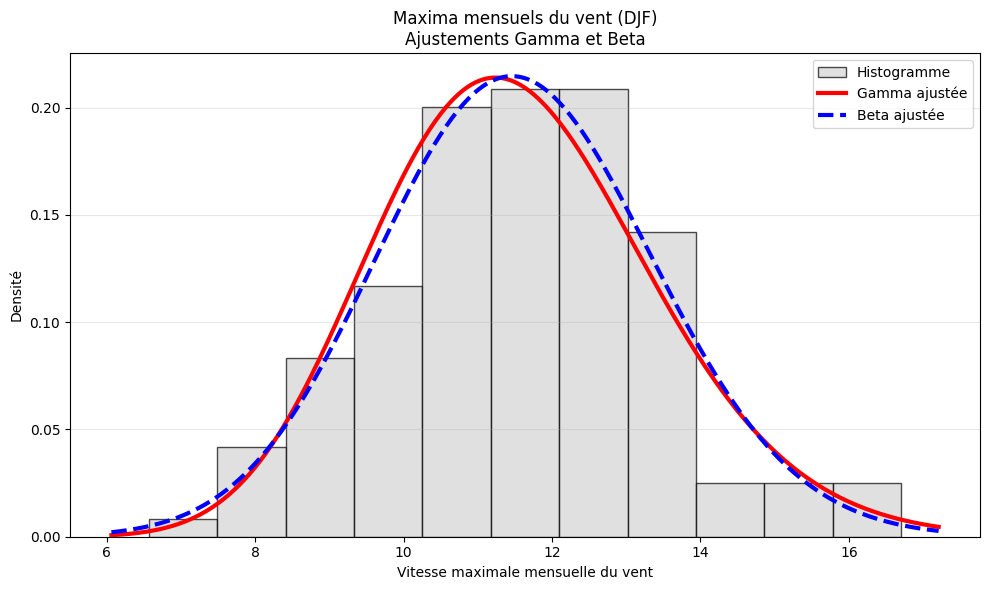

In [67]:
# Données : maxima mensuels du vent
Z = Y_max_month[:-1]   # on enlève la dernière si besoin

# Histogramme
plt.figure(figsize=(10,6))
bins = int(np.sqrt(len(Z)))

plt.hist(Z, bins=bins, density=True,
         color='lightgrey', edgecolor='black', alpha=0.7,
         label='Histogramme')

xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 300)

# GAMMA
Z_pos = Z[Z > 0]                           # Gamma → valeurs positives
alpha, loc_g, scale_g = gamma.fit(Z_pos, floc=0)

plt.plot(xx, gamma.pdf(xx, alpha, loc=0, scale=scale_g),
         'r-', lw=3, label='Gamma ajustée')

# p-value KS Gamma
ks_g, p_g = kstest(Z_pos, 'gamma', args=(alpha, 0, scale_g))

# BETA
a, b, loc_b, scale_b = beta_dist.fit(Z)

plt.plot(xx, beta_dist.pdf(xx, a, b, loc=loc_b, scale=scale_b),
         'b--', lw=3, label='Beta ajustée')

# p-value KS Beta
ks_b, p_b = kstest(Z, 'beta', args=(a, b, loc_b, scale_b))

# Résultats statistiques
print(" Gamma ")
print("alpha =", alpha)
print("scale =", scale_g)
print("KS p-value =", p_g)

print("\n Beta ")
print("a =", a, " b =", b)
print("loc =", loc_b, " scale =", scale_b)
print("KS p-value =", p_b)
# Plot final
plt.xlabel("Vitesse maximale mensuelle du vent")
plt.ylabel("Densité")
plt.title("Maxima mensuels du vent (DJF)\nAjustements Gamma et Beta")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.GEV max vent mensuel

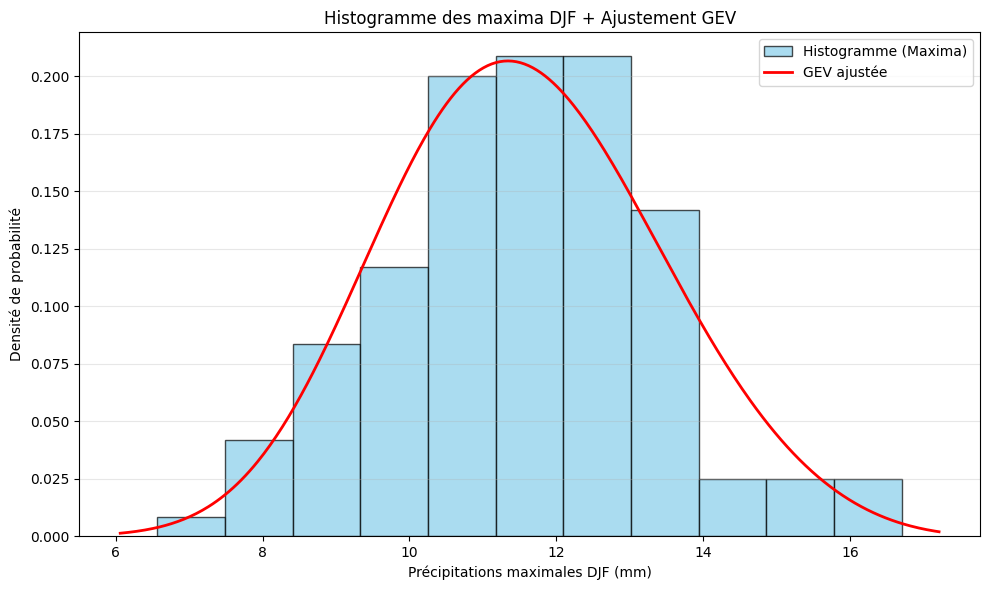

Paramètres GEV : shape(c)=0.240, loc=10.9, scale=1.8


In [68]:
# Ajustement GEV
cw1, locw1, scalew1 = genextreme.fit(Y_max_month[:-1])

# Histogramme des maxima
plt.figure(figsize=(10,6))
bins = int(np.sqrt(len(Y_max_month[:-1])))
plt.hist(Y_max_month[:-1], bins=bins, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogramme (Maxima)')

# Courbe GEV ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genextreme.pdf(xx, cw1, locw1, scalew1), 'r-', lw=2, label='GEV ajustée')

plt.xlabel("Précipitations maximales DJF (mm)")
plt.ylabel("Densité de probabilité")
plt.title("Histogramme des maxima DJF + Ajustement GEV")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Paramètres GEV
print(f"Paramètres GEV : shape(c)={cw1:.3f}, loc={locw1:.1f}, scale={scalew1:.1f}")


In [69]:
# Construction de la CDF paramétrée
gev_cdf = lambda x: genextreme(cw1, loc=locw1, scale=scalew1).cdf(x)

# KS-test
ks_stat, ks_p = kstest(Y_max_month[:-1], gev_cdf)

print("Test KS (GEV ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

Test KS (GEV ajustée) :
  Statistique = 0.04429945229005028
  p-value     = 0.9506669495236346


### 5.GPD sur les moyennes de vent mensuelles

In [70]:
# Moyenne par mois (année–mois)
Y_moy_mois_val = Y.groupby(year_month).mean()

# Maintenant c’est un DataArray 1D
print(Y_moy_mois_val.shape)

(131,)


Nombre d'excès : 39


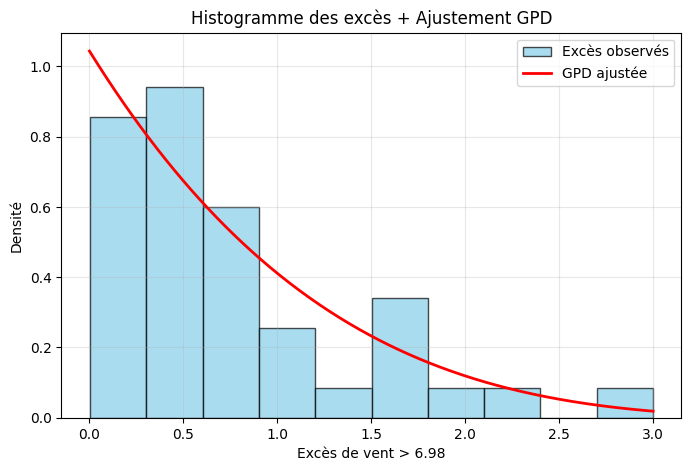

Test KS (GPD ajustée)
  Statistique = 0.1047686056098347
  p-value     = 0.7462390832696267
Log-vraisemblance = -29.175464878184314
AIC GPD = 62.35092975636863
Paramètres GPD : shape=-0.209, scale=0.958


In [71]:
# 1. Seuil (70e percentile)
Y_np = np.asarray(Y_moy_mois_val)
Y_np = Y_np[np.isfinite(Y_np)]

seuil = np.percentile(Y_np, threshold)

# Excès
exceedances_YM = Y_np[Y_np > seuil] - seuil
print("Nombre d'excès :", len(exceedances_YM))

# 2. Ajustement GPD
c5, loc5, scale5 = genpareto.fit(exceedances_YM, floc=0)

# 3. Histogramme + GPD
plt.figure(figsize=(8,5))
plt.hist(exceedances_YM, bins=10, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Excès observés')

xx = np.linspace(0, exceedances_YM.max(), 400)
plt.plot(xx, genpareto.pdf(xx, c5, loc=0, scale=scale5),
         'r-', lw=2, label='GPD ajustée')

plt.xlabel(f"Excès de vent > {seuil:.2f}")
plt.ylabel("Densité")
plt.title("Histogramme des excès + Ajustement GPD")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 4. Test KS
ks_stat, ks_p = kstest(
    exceedances_YM,
    lambda x: genpareto.cdf(x, c5, loc=0, scale=scale5)
)

print("Test KS (GPD ajustée)")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# 5. Log-vraisemblance et AIC
logL = np.sum(genpareto.logpdf(exceedances_YM, c5, loc=0, scale=scale5))
AIC_gpd = 2*2 - 2*logL   # k = 2 (shape + scale, loc fixé)

print("Log-vraisemblance =", logL)
print("AIC GPD =", AIC_gpd)

# 6. Paramètres
print(f"Paramètres GPD : shape={c5:.3f}, scale={scale5:.3f}")


##**Tableau recapitulatif des tests => Valider distribution**

In [72]:
import numpy as np
from scipy.stats import norm, gamma, beta as beta_dist, shapiro, kstest
from scipy.stats import genextreme, genpareto

def test_distributions(data, var_name, gpd_threshold=None):
    results = []

    data = np.asarray(data)
    data = data[np.isfinite(data)]

    # Normale
    mu, sigma = norm.fit(data)
    logL = np.sum(norm.logpdf(data, mu, sigma))
    AIC = 2*2 - 2*logL

    ks_stat, ks_p = kstest(data, 'norm', args=(mu, sigma))
    sh_stat, sh_p = shapiro(data[:5000])

    results.append([var_name, "Normale", ks_p, sh_p, AIC])

    # Gamma (positives)
    data_pos = data[data > 0]
    a, loc, scale = gamma.fit(data_pos, floc=0)
    logL = np.sum(gamma.logpdf(data_pos, a, 0, scale))
    AIC = 2*2 - 2*logL

    ks_stat, ks_p = kstest(data_pos, 'gamma', args=(a, 0, scale))

    results.append([var_name, "Gamma", ks_p, None, AIC])

    # Beta
    a, b, loc, scale = beta_dist.fit(data)
    logL = np.sum(beta_dist.logpdf(data, a, b, loc, scale))
    AIC = 2*4 - 2*logL   # a, b, loc, scale

    ks_stat, ks_p = kstest(data, 'beta', args=(a, b, loc, scale))

    results.append([var_name, "Beta", ks_p, None, AIC])

    # GEV (pour maxima)
    c, loc, scale = genextreme.fit(data)
    logL = np.sum(genextreme.logpdf(data, c, loc, scale))
    AIC = 2*3 - 2*logL

    ks_stat, ks_p = kstest(data, 'genextreme', args=(c, loc, scale))

    results.append([var_name, "GEV", ks_p, None, AIC])

    # GPD (POT)
    if gpd_threshold is not None:
        exceedances = data[data > gpd_threshold] - gpd_threshold

        if len(exceedances) > 20:  # sécurité
            c, loc, scale = genpareto.fit(exceedances, floc=0)
            logL = np.sum(genpareto.logpdf(exceedances, c, 0, scale))
            AIC = 2*2 - 2*logL

            ks_stat, ks_p = kstest(exceedances, 'genpareto', args=(c, 0, scale))

            results.append([var_name, "GPD", ks_p, None, AIC])

    return results


In [73]:
table_results = []

table_results += test_distributions(
    X,
    "Précipitations journalières DJF (X)",
    gpd_threshold=np.percentile(X, threshold)
)

table_results += test_distributions(
    Somme_mois,
    "Précipitations mensuelles DJF (Somme)",
    gpd_threshold=np.percentile(Somme_mois, threshold)
)

table_results += test_distributions(
    WinterPI,
    "Précipitations hivernales DJF (WPI)",
    gpd_threshold=np.percentile(WinterPI, threshold)
)

table_results += test_distributions(
    Y,
    "Vent moyen journalier DJF (Y)",
    gpd_threshold=np.percentile(Y, threshold)
)

table_results += test_distributions(
    Y_max_month,
    "Vent maximal mensuel DJF",
    gpd_threshold=np.percentile(Y_max_month, threshold)
)


/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


In [74]:
import pandas as pd

df_results = pd.DataFrame(
    table_results,
    columns=["Variable", "Loi", "KS p-value", "Shapiro p-value", "AIC"]
)

df_results


,Variable,Loi,KS p-value,Shapiro p-value,AIC
0,Précipitations journalières DJF (X),Normale,7.347249e-221,1.537677e-64,54431.456609
1,Précipitations journalières DJF (X),Gamma,5.671534e-03,NaN,43796.402318
2,Précipitations journalières DJF (X),Beta,1.055687e-191,NaN,49089.770783
3,Précipitations journalières DJF (X),GEV,3.284046e-36,NaN,46423.526607
4,Précipitations journalières DJF (X),GPD,6.328844e-01,NaN,15642.485249
5,Précipitations mensuelles DJF (Somme),Normale,1.638523e-01,2.272107e-03,2410.726571
6,Précipitations mensuelles DJF (Somme),Gamma,9.501664e-01,NaN,2399.893699
7,Précipitations mensuelles DJF (Somme),Beta,8.397134e-01,NaN,2398.849789
8,Précipitations mensuelles DJF (Somme),GEV,3.643568e-55,NaN,3007.418648
9,Précipitations mensuelles DJF (Somme),GPD,6.330552e-01,NaN,665.626707


# **IV/ Etude multivariée**

## Etude de la dépendance X-Y

### 1.Tracé du nuage de points des précipitations et des vents journaliers

In [75]:
# 1. Alignement des données (Sécurité pour s'assurer que les dates correspondent)
# On convertit les DataArrays X et Y en Séries Pandas indexées par le temps
df_X = X.to_dataframe(name='precip').reset_index().set_index('time')['precip']
df_Y = Y.to_dataframe(name='wind').reset_index().set_index('time')['wind']

# On joint les deux séries sur l'index temporel (intersection des dates)
df_joint = pd.concat([df_X, df_Y], axis=1, join='inner').dropna()

# Définition des vecteurs alignés
X_joint = df_joint['precip'].values
Y_joint = df_joint['wind'].values

print(f"Tous les jours sont conservés : {len(df_joint)==7550}")
print(df_X)
print(df_joint)
print(X_joint)
print(len(X_joint))

Tous les jours sont conservés : False
time
1980-01-01    483.024048
1980-01-02      1.424419
1980-01-03    233.279388
1980-01-04    301.138062
1980-01-05     90.325714
                 ...    
2023-02-24     48.115875
2023-02-25     11.824375
2023-02-26      1.189961
2023-02-27      2.132847
2023-02-28    187.348373
Name: precip, Length: 3940, dtype: float32
                precip      wind
time                            
1980-01-01  483.024048  4.954326
1980-01-02    1.424419  3.892266
1980-01-03  233.279388  7.179086
1980-01-04  301.138062  8.098825
1980-01-05   90.325714  6.938196
...                ...       ...
2023-02-24   48.115875  7.247035
2023-02-25   11.824375  6.912128
2023-02-26    1.189961  8.036705
2023-02-27    2.132847  7.903212
2023-02-28  187.348373  7.378880

[3940 rows x 2 columns]
[483.02405     1.4244189 233.27939   ...   1.1899608   2.1328468
 187.34837  ]
3940


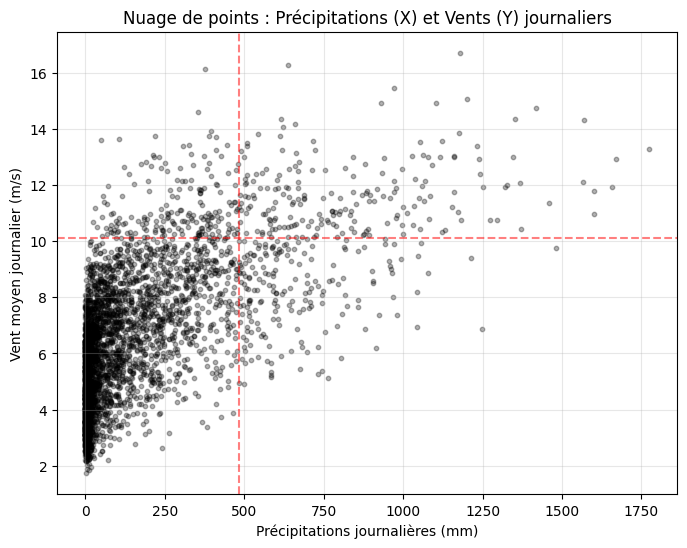

In [76]:
p = 90  # seuil à 90%
seuil_X = np.percentile(X_joint, p)
seuil_Y = np.percentile(Y_joint, p)

# 2. Visualisation de la dépendance brute (Nuage de points)
plt.figure(figsize=(8, 6))
# Zoom sur le coin supérieur droit (les extrêmes)
plt.axvline(seuil_X, color='r', linestyle='--', alpha=0.5)
plt.axhline(seuil_Y, color='r', linestyle='--', alpha=0.5)
plt.scatter(X_joint, Y_joint, alpha=0.3, s=10, c='black', label='Observations')
plt.xlabel("Précipitations journalières (mm)")
plt.ylabel("Vent moyen journalier (m/s)")
plt.title("Nuage de points : Précipitations (X) et Vents (Y) journaliers")
plt.grid(alpha=0.3)
plt.show()

In [77]:
# 3. Calcul des Corrélations
# Pearson (linéaire, sensible aux non-gaussianités)
pearson_corr, p_val_p = st.pearsonr(X_joint, Y_joint)
# Kendall (rangs, peu sensible aux valeurs extrêmes, approprié ici car marges non normales)
kendall_corr, p_val_k = st.kendalltau(X_joint, Y_joint)
# Spearman (rangs)
spearman_corr, p_val_s = st.spearmanr(X_joint, Y_joint)

print(f"Pearson  (r)   : {pearson_corr:.3f}")
print(f"Spearman (rho) : {spearman_corr:.3f}")
print(f"Kendall  (tau) : {kendall_corr:.3f}")

Pearson  (r)   : 0.649
Spearman (rho) : 0.685
Kendall  (tau) : 0.488



***1. Une corrélation positive***

L'orientation générale du nuage va du bas-gauche vers le haut-droite.

* **Observation :** De manière générale, plus les précipitations (X) sont élevées, plus la vitesse du vent (Y) est élevée.
* **Confirmation :** Cela valide visuellement le coefficient de corrélation (Kendall , Spearman ).

***2. Le coin vide (asymétrie)***

La forme du nuage est **triangulaire** ou en forme d'éventail.

* **Coin inférieur droit (Vide) :** Il n'y a **aucun point** avec de très fortes précipitations ( mm cumulés) et un vent faible ( m/s).
* *Interprétation :* En hiver en Bretagne, les fortes pluies sont apportées par des dépressions dynamiques venant de l'Atlantique. Il est physiquement impossible d'avoir ce type de pluie sans le vent associé. (pas comme un phénomène type mousson)


* **Coin supérieur gauche (Peuplé) :** Il y a des points avec un vent fort ( m/s) mais peu de précipitations.
* *Interprétation physique :* Il est possible d'avoir des tempêtes "sèches" ou des coups de vent sans pluie massive, même si c'est moins fréquent que les tempêtes humides.



***3. La dépendance dans les extrêmes (Queue supérieure)***

A la droite du graphique:

* Dès que les précipitations deviennent extrêmes, le vent est **systématiquement fort** (il se concentre dans la partie haute, majoritairement au-dessus de 10 m/s).
* Cela indique une **forte dépendance de queue supérieure**. Les extrêmes des deux variables ont tendance à se produire simultanément (Clustering).
* C'est un argument fort pour l'utilisation de la **Copule de Gumbel**, qui est spécialisée pour modéliser ce genre de dépendance dans les maxima conjoints.

***4. La densité des données (Le "coeur" de la distribution)***

* La grande majorité des points (la tache noire dense) se situe entre 0 et 500 mm pour la pluie, et entre 4 et 10 m/s pour le vent.
* Cela rappelle que les événements extrêmes que nous étudions (les points gris dispersés vers la droite et le haut) sont rares par rapport au climat moyen, d'où l'importance d'utiliser la théorie des valeurs extrêmes (GPD/GEV) pour les marges.

***Conclusion***

Ce graphique illustre le concept d'**événement composé** : le risque d'inondation (lié à la pluie) est aggravé par le risque de submersion ou de dégâts éoliens (lié au vent) car les deux surviennent souvent en même temps.

**Prochaine étape suggérée :** Lancer le code de comparaison des copules Gumbel vs Clayton vs Gauss. Ce graphique suggère fortement que **Gumbel** sera le meilleur modèle car il capture bien cette "pointe" vers le haut-droite, contrairement à la Gaussienne qui chercherait une forme elliptique plus symétrique.

### 2.Etude de la copule empirique (Approche par les rangs)

True
[0.30220756 0.14285714 0.63511799 ... 0.74118244 0.72595788 0.65820858]


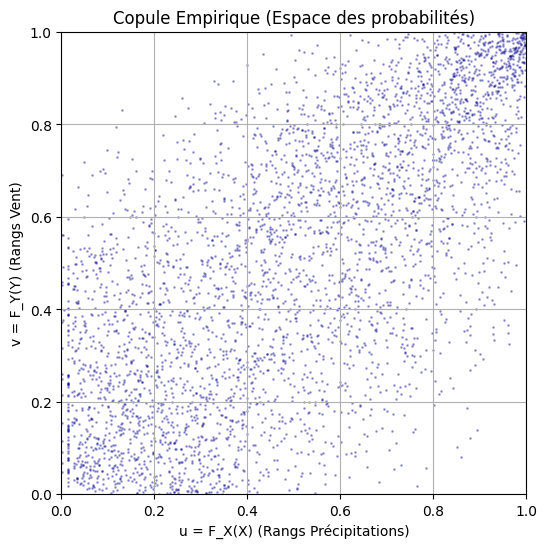

In [78]:
# Comme les lois marginales sont complexes (GPD en queue, etc.), on passe
# dans l'espace des rangs (espace uniforme [0,1], cdf empirique) pour voir la structure de dépendance pure.

# Transformation en pseudo-observations (u, v)
u = st.rankdata(X_joint) / (len(X_joint) + 1)
v = st.rankdata(Y_joint) / (len(Y_joint) + 1)

print(len(u)==len(v))
print(v)

plt.figure(figsize=(6, 6))
plt.scatter(u, v, s=1, alpha=0.3, color='darkblue')
plt.xlabel("u = F_X(X) (Rangs Précipitations)")
plt.ylabel("v = F_Y(Y) (Rangs Vent)")
plt.title("Copule Empirique (Espace des probabilités)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Interprétation visuelle :
# - Si les points sont partout : Indépendance.
# - Si les points se regroupent le long de la diagonale (bas-gauche vers haut-droite) : Dépendance positive.
# - Regardez le coin haut-droit (1,1) : Y a-t-il une concentration ? (Dépendance de queue supérieure).

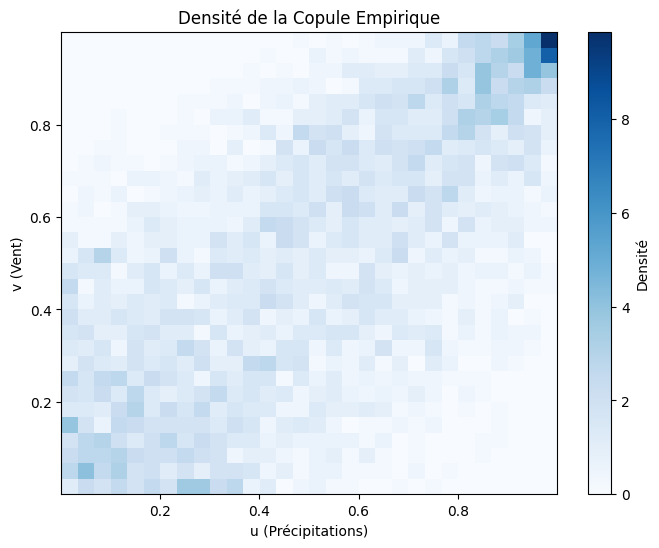

In [79]:
# La densité des copules (heatmap)
def heatmap(u, v, n_bins=100):
    n = len(u)


    plt.figure(figsize=(8, 6))
    plt.hist2d(u, v, bins=30, cmap="Blues", density=True)
    plt.colorbar(label="Densité")
    plt.xlabel("u (Précipitations)")
    plt.ylabel("v (Vent)")
    plt.title("Densité de la Copule Empirique")
    plt.show()

heatmap(u, v)

Ce graphique montre la **structure de dépendance pure** (en probabilités/rangs), débarrassée des unités et des formes de distribution.

C'est une transformation du premier. On a remplacé chaque valeur par son "rang" (entre 0 et 1).

*  u≈0: Jour sec  / u≈1: Jour pluvieux
*  v≈0: Jour sans vent /  v≈1: Jour plus venteux

Description du graphe:

* **Concentration sur la diagonale :** Les points bleus ne sont pas éparpillés au hasard (ce qui signifierait l'indépendance). Ils ont tendance à suivre la ligne .
* **Le Cluster en (1, 1) :** signifie que les jours les plus pluvieux sont presque systématiquement les jours les plus venteux = Dépendance de Queue Supérieure (Upper Tail Dependence).

* La dépendance est plus forte dans le coin (1,1) que dans le coin (0,1) ou (1,0).

***Conclusion***

1. On ne peut pas utiliser une loi Gaussienne classique (car elle suppose une symétrie et pas de dépendance de queue forte).
2. La concentration intense dans le coin (1,1) de la Copule Empirique est la signature typique d'une **Copule de Gumbel**.

### 3.Calcul Observé/Independant:

In [80]:
# # Calcul de la probabilité conjointe d'un événement extrême (Concurrent extremes)
# # Exemple : Quelle est la probabilité d'avoir SIMULTANEMENT :
# # Pluie > percentile 95 ET Vent > percentile 95
# seuil_u = 0.95
# seuil_v = 0.95

# p_joint_extreme = np.sum((u > seuil_u) & (v > seuil_v)) / len(u)
# p_theoretical_indep = (1 - seuil_u) * (1 - seuil_v)

# print(f"Analyse des extrêmes conjoints (Seuil 95%):")
# print(f"Probabilité théorique (si indépendants) : {p_theoretical_indep:.4f}")
# print(f"Probabilité empirique observée          : {p_joint_extreme:.4f}")

# ratio = p_joint_extreme / p_theoretical_indep
# print(f"Ratio (Obsevée / Indep) : {ratio:.2f}")
# if ratio > 1:
#     print("Conclusion : Le ratio est > 1, donc les extrêmes de pluie et de vent ont tendance à arriver en même temps (Clustering).")
# else:
#     print("Conclusion : Pas de dépendance particulière dans les extrêmes.")

***1. Hypothèse d'Indépendance***

* **Calcul :** On regarde les événements extrêmes, ceux qui dépassent le seuil de 95%. Si la pluie et le vent n'avaient aucun lien, la probabilité d'avoir les deux en même temps serait simplement le produit des probabilités soit 0,05×0,05= 0,25%


* **Signification :** Avec cette hypothèse, une tempête combinée (pluie + vent extrêmes) est un événement très rare.

***2. La Réalité Observée (L'empirique)***

* **Chiffre :** 1,92%
* **Signification :** Dans les données historiques, ce scénario arrive en réalité **près de 2% du temps**, et non 0,25%. C'est donc beaucoup plus fréquent que prévu par le modèle indépendant.

***3. Le Ratio***
Le Facteur d'Aggravation: 7,68

* **Interprétation :** Il y a **près de 8 fois plus de chances** de subir une tempête majeure que si les deux phénomènes étaient indépendants.


***4. Conclusion Physique : "Compound Events"***

Ce résultat confirme statistiquement la réalité météorologique de la Bretagne en hiver :

* Les **dépressions atlantiques** sont des systèmes physiques qui apportent **à la fois** des basses pressions (donc du vent fort) et des fronts humides (donc de la pluie intense).

Cela prouve mathématiquement que considérer la pluie et le vent comme indépendants serait une grave erreur pour l'évaluation des risques en Bretagne.

 = **forte dépendance de queue supérieure**. Les extrêmes s'attirent. Cela justifie l'utilisation d'une **Copule de Gumbel** (spécialisée dans les extrêmes simultanés) pour modéliser le risque conjoint.

###4.Calcul en séparant queue de distribution GPD :

Seuils définis : X > 483.01 | Y > 10.11
394
201


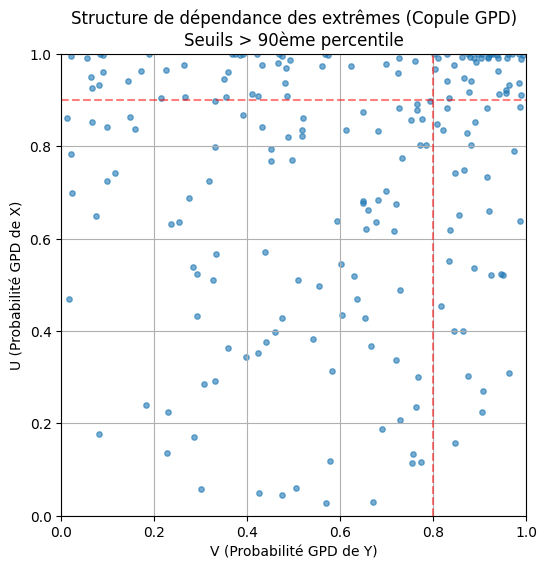

In [81]:

def gpd_transform_tail(data, threshold, gpd_params):
    """
    1. Isole les valeurs > seuil.
    2. Soustrait le seuil pour avoir les excès.
    3. Transforme les excès en probabilités [0, 1] via la CDF de la GPD.
    """
    data = np.array(data)
    xi, loc, sigma = gpd_params # xi (shape), loc (0), sigma (scale)

    # 1. Masque : on ne garde que ce qui dépasse le seuil
    mask_tail = data > threshold

    # 2. Excès : GPD travaille sur (Valeur - Seuil)
    excess = data[mask_tail] - threshold

    # 3. Transformation en probabilités (0 à 1)
    # Note : on met loc=0 car on a déjà soustrait le seuil manuellement juste au-dessus
    tail_probs = genpareto.cdf(excess, xi, loc=0, scale=sigma)

    return mask_tail, tail_probs

#  1. Définition correcte des seuils

t = 90  # seuil à 90%
seuil_X = np.percentile(X_joint, t)
seuil_Y = np.percentile(Y_joint, t)

print(f"Seuils définis : X > {seuil_X:.2f} | Y > {seuil_Y:.2f}")

#  2. Transformation Marginale GPD
# On récupère U et V qui sont les probabilités GPD (entre 0 et 1)

mask_X, U_gpd = gpd_transform_tail(X_joint, seuil_X, (c4, loc4, scale4))
mask_Y, V_gpd = gpd_transform_tail(Y_joint, seuil_Y, (c5, loc5, scale5))

#  3. Intersection (Extraction des extrêmes conjoints)
# On cherche les indices où X ET Y dépassent TOUS LES DEUX le seuil
mask_conjoint = mask_X & mask_Y

# mask_conjoint[mask_X] sélectionne, PARMI les extrêmes de X, ceux où Y est aussi extrême.
U_conjoint = U_gpd[mask_conjoint[mask_X]]
V_conjoint = V_gpd[mask_conjoint[mask_Y]]

print(len(U_gpd))

print(len(U_conjoint))

#  4. Visualisation de la dépendance de queue
plt.figure(figsize=(6, 6))
plt.scatter(U_conjoint, V_conjoint, s=15, alpha=0.6)

plt.title(f"Structure de dépendance des extrêmes (Copule GPD)\nSeuils > {p}ème percentile")
plt.xlabel("V (Probabilité GPD de Y)")
plt.ylabel("U (Probabilité GPD de X)")
# Zoom sur le coin supérieur droit (les extrêmes)
plt.axvline(0.80, color='r', linestyle='--', alpha=0.5)
plt.axhline(0.90, color='r', linestyle='--', alpha=0.5)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [82]:
# création x et y au dessus du seuil.
X_extremes = X_joint[mask_X]
Y_extremes = Y_joint[mask_Y]

X_conjoint = X_joint[mask_conjoint]
Y_conjoint = Y_joint[mask_conjoint]

# 3. Calcul des Corrélations
# Pearson (linéaire, sensible aux non-gaussianités)
pearson_corr, p_val_p = st.pearsonr(X_conjoint, Y_conjoint)

# Kendall (rangs, peu sensible aux valeurs extrêmes, approprié ici car marges non normales)
kendall_corr, p_val_k = st.kendalltau(X_conjoint, Y_conjoint)
# Spearman (rangs)
spearman_corr, p_val_s = st.spearmanr(X_conjoint, Y_conjoint)

print(f"Pearson  (r)   : {pearson_corr:.3f}")
print(f"Spearman (rho) : {spearman_corr:.3f}")
print(f"Kendall  (tau) : {kendall_corr:.3f}")

print ("extremes")

# 3. Calcul des Corrélations
# Pearson (linéaire, sensible aux non-gaussianités)
pearson_corr, p_val_p = st.pearsonr(X_extremes, Y_extremes)

# Kendall (rangs, peu sensible aux valeurs extrêmes, approprié ici car marges non normales)
kendall_corr, p_val_k = st.kendalltau(X_extremes, Y_extremes)
# Spearman (rangs)
spearman_corr, p_val_s = st.spearmanr(X_extremes, Y_extremes)

print(f"Pearson  (r)   : {pearson_corr:.3f}")
print(f"Spearman (rho) : {spearman_corr:.3f}")
print(f"Kendall  (tau) : {kendall_corr:.3f}")

Pearson  (r)   : 0.218
Spearman (rho) : 0.151
Kendall  (tau) : 0.104
extremes
Pearson  (r)   : 0.094
Spearman (rho) : 0.014
Kendall  (tau) : 0.008


In [83]:
u = U_conjoint
v = V_conjoint
# Définition des bornes du carré
u_min = 0.90
v_min = 0.80

# Masque des points dans le carré (coin supérieur droit)
mask_carre = (u >= u_min) & (v >= v_min)

# Nombre de points
nb_points_carre = np.sum(mask_carre)

print("Nombre de points dans le carré encadré :", nb_points_carre)
print("Nombre total d'extrêmes conjoints :", len(u))
print("Proportion dans le carré :", nb_points_carre / len(u))

Nombre de points dans le carré encadré : 24
Nombre total d'extrêmes conjoints : 201
Proportion dans le carré : 0.11940298507462686


In [84]:
print("u max:", u.max(), "  v_gpd max:", v.max())
print("top 5 u:", np.sort(u)[-5:])
print("top 5 v:", np.sort(v)[-5:])

u max: 0.9929252117226681   v_gpd max: 1.0
top 5 u: [0.98547456 0.98555125 0.98848197 0.98907821 0.99292521]
top 5 v: [1. 1. 1. 1. 1.]


In [85]:
# 4. Analyse des extrêmes corrigée
# On recalcule la probabilité conjointe avec les vecteurs u et v
prob_joint_extreme = np.sum((u > u_min) & (v > v_min)) / len(u)
print(f"Probabilité conjointe (extrêmes > 90%) avec GPD : {prob_joint_extreme:.5f}")

Probabilité conjointe (extrêmes > 90%) avec GPD : 0.11940


In [86]:
# 3. Calcul des Corrélations
# Pearson (linéaire, sensible aux non-gaussianités)
pearson_corr, p_val_p = st.pearsonr(u,v)
# Kendall (rangs, peu sensible aux valeurs extrêmes, approprié ici car marges non normales)
kendall_corr, p_val_k = st.kendalltau(u,v)
# Spearman (rangs)
spearman_corr, p_val_s = st.spearmanr(u,v)

print(f"Pearson  (r)   : {pearson_corr:.3f}")
print(f"Spearman (rho) : {spearman_corr:.3f}")
print(f"Kendall  (tau) : {kendall_corr:.3f}")

Pearson  (r)   : 0.082
Spearman (rho) : 0.152
Kendall  (tau) : 0.105


## La Copule:

### Visualisation des copules:

Rappel du cours: (a priori Gumbel pour les upper tails mieux)

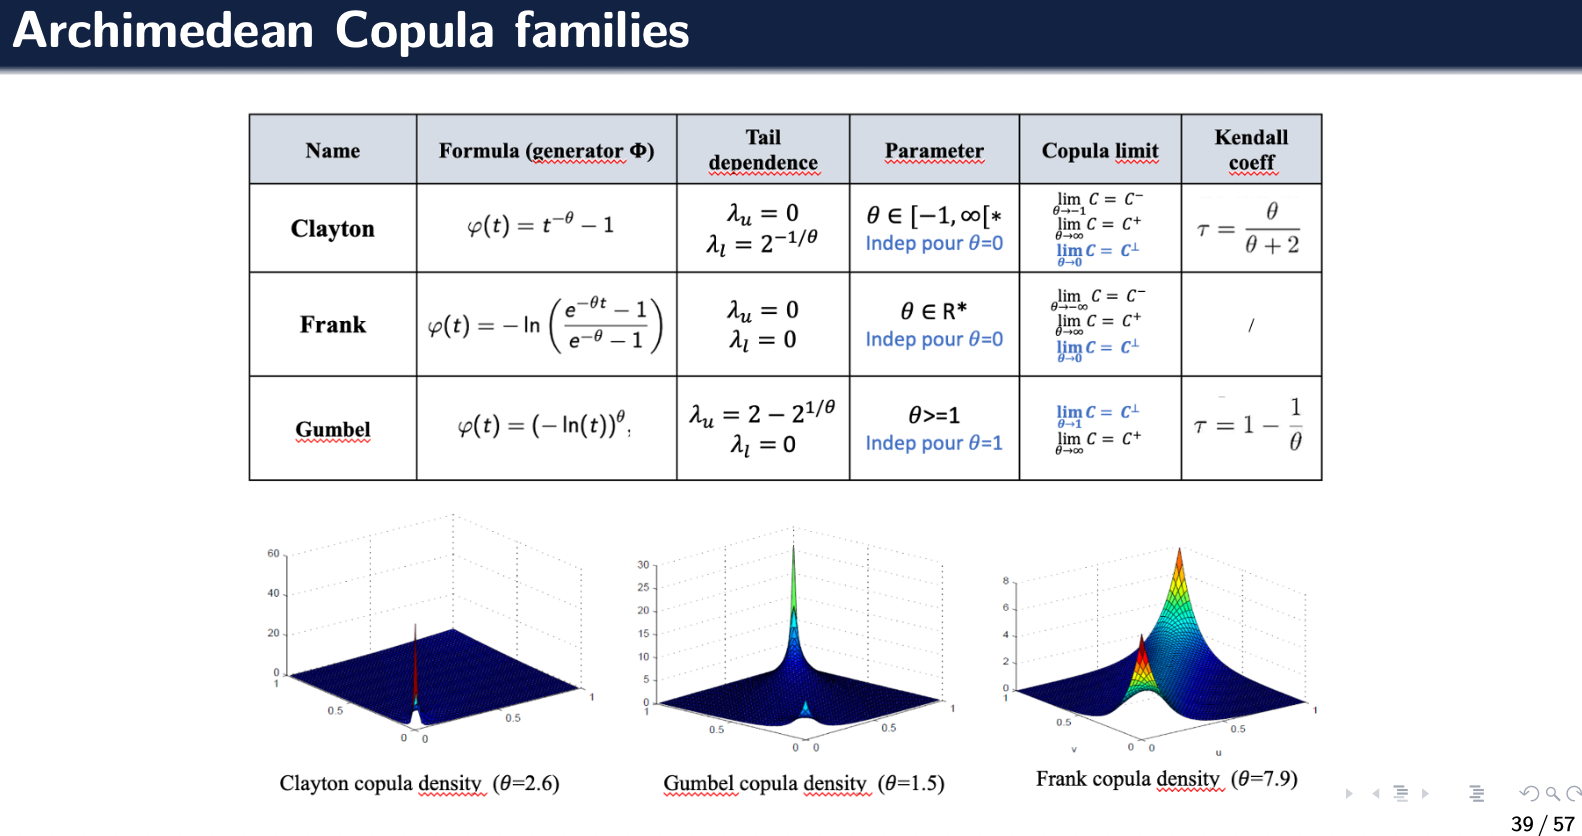

On compare quand même les copules archimédiennes:
Pour ça, on calcule les paramètres de chaque copule avec les formules ci-dessus, puis on trouve les pdfs et on trace les graphiques données et iso

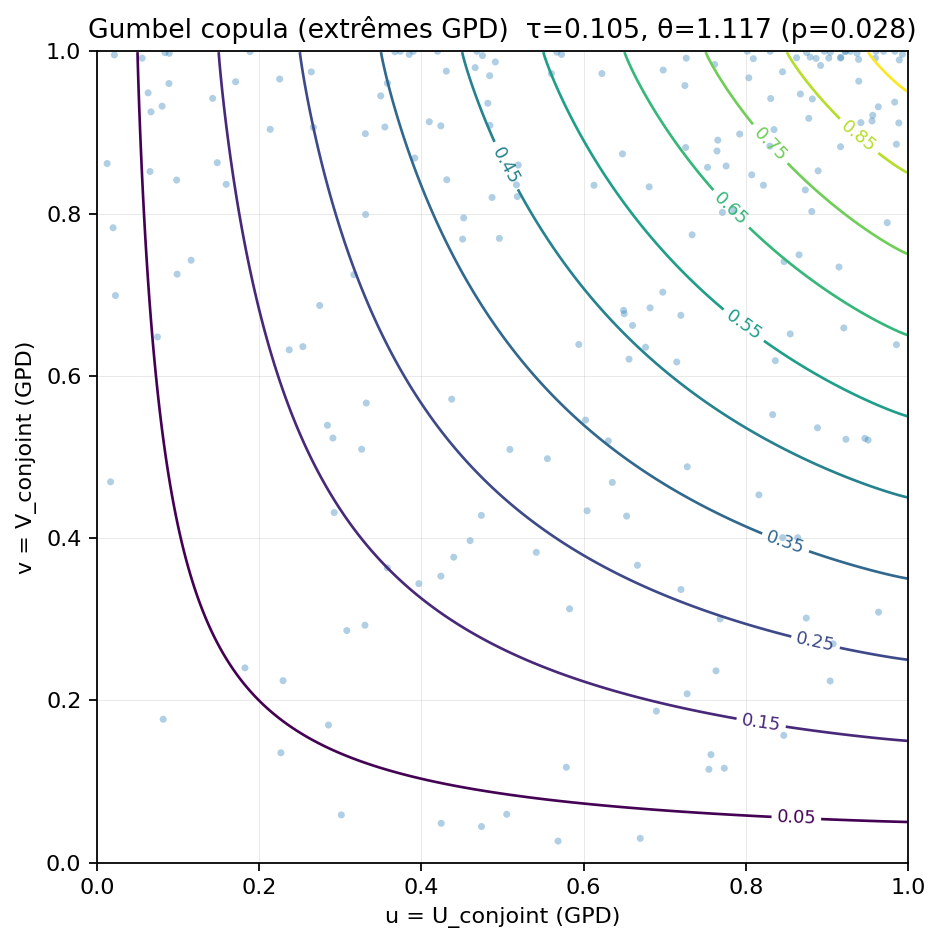

In [87]:
# 1) Tau -> theta (Gumbel copula) SUR CES u,v
tau, pval = kendalltau(u, v)
if tau <= 0:
    raise ValueError("Copule de Gumbel: dépendance positive requise (tau > 0).")

theta = 1 / (1 - tau)  # Gumbel: tau = 1 - 1/theta

# 2) Fonction copule de Gumbel
def gumbel_copula_C(U, V, theta):
    U = np.clip(U, 1e-12, 1 - 1e-12)
    V = np.clip(V, 1e-12, 1 - 1e-12)
    return np.exp(-(((-np.log(U))**theta + (-np.log(V))**theta)**(1/theta)))

# 3) Tracé contours + points (u,v)
grid = np.linspace(1e-3, 1 - 1e-3, 300)
U_grid, V_grid = np.meshgrid(grid, grid)
C = gumbel_copula_C(U_grid, V_grid, theta)

fig, ax = plt.subplots(figsize=(6.5, 6), dpi=160)

levels = np.linspace(0.05, 0.95, 10)
cs = ax.contour(U_grid, V_grid, C, levels=levels, linewidths=1.2)
ax.clabel(cs, fmt="%.2f", fontsize=8)

ax.scatter(u, v, s=10, alpha=0.35, edgecolors="none")

ax.set_aspect("equal")
ax.set_xlim(0, 1); ax.set_ylim(0, 1)
ax.set_xlabel("u = U_conjoint (GPD)")
ax.set_ylabel("v = V_conjoint (GPD)")
ax.set_title(f"Gumbel copula (extrêmes GPD)  τ={tau:.3f}, θ={theta:.3f} (p={pval:.2g})")
ax.grid(True, linewidth=0.4, alpha=0.3)

plt.tight_layout()
plt.show()


In [88]:
# 1. Récupération du Tau de Kendall calculé précédemment
print(f"Tau de Kendall utilisé pour l'estimation : {tau:.4f}")

# 2. Estimation des paramètres (Méthode des Moments via Kendall's Tau)

# Copule de Gumbel (Dépendance de queue supérieure, extrêmes forts)
# Relation : tau = 1 - 1/theta
theta_gumbel = 1 / (1 - tau)
print(f"Paramètre Gumbel estimé (theta) : {theta_gumbel:.4f}")

# Copule de Clayton (Dépendance de queue inférieure, valeurs faibles)
# Relation : tau = theta / (theta + 2)
theta_clayton = 2 * tau / (1 - tau)
print(f"Paramètre Clayton estimé (theta) : {theta_clayton:.4f}")

# Copule Gaussienne (Symétrique)
# Relation : r = sin(pi/2 * tau)
rho_gauss = np.sin(np.pi / 2 * tau)
print(f"Paramètre Gaussien estimé (rho) : {rho_gauss:.4f}")

Tau de Kendall utilisé pour l'estimation : 0.1046
Paramètre Gumbel estimé (theta) : 1.1168
Paramètre Clayton estimé (theta) : 0.2336
Paramètre Gaussien estimé (rho) : 0.1635


In [89]:
# 3. Simulation pour Comparaison Visuelle
# On génère des données artificielles avec ces lois pour voir laquelle ressemble à nos données

# Pour simplifier l'affichage sans librairie 'copulae' lourde,
# nous allons tracer les isolignes de densité théorique sur les données empiriques (Rangs).

# Grille pour les contours
u_grid = np.linspace(0.01, 0.99, 100)
v_grid = np.linspace(0.01, 0.99, 100)
U_grid, V_grid = np.meshgrid(u_grid, v_grid)

# Formules des Densités de Copules (PDF)

def pdf_gumbel(u, v, theta):
    u = np.asarray(u); v = np.asarray(v)
    eps = 1e-12
    u = np.clip(u, eps, 1-eps)
    v = np.clip(v, eps, 1-eps)

    x = -np.log(u)
    y = -np.log(v)

    s = x**theta + y**theta
    a = s**(1/theta)
    C = np.exp(-a)

    pdf = C * (x*y)**(theta-1) / (u*v) * s**(1/theta - 2) * (a + theta - 1)
    return pdf


def pdf_clayton(u, v, theta):
    val = (u**(-theta) + v**(-theta) - 1)**(-1/theta - 2)
    return (1 + theta) * (u * v)**(-theta - 1) * val

def pdf_gauss(u, v, rho):
    x = norm.ppf(u)
    y = norm.ppf(v)
    num = np.exp(-(rho**2 * (x**2 + y**2) - 2*rho*x*y) / (2*(1-rho**2)))
    den = np.sqrt(1 - rho**2)
    return num / den

In [90]:
# u, v = extrêmes conjoints GPD
u = np.asarray(U_conjoint)
v = np.asarray(V_conjoint)

mask = np.isfinite(u) & np.isfinite(v)
u = u[mask]; v = v[mask]

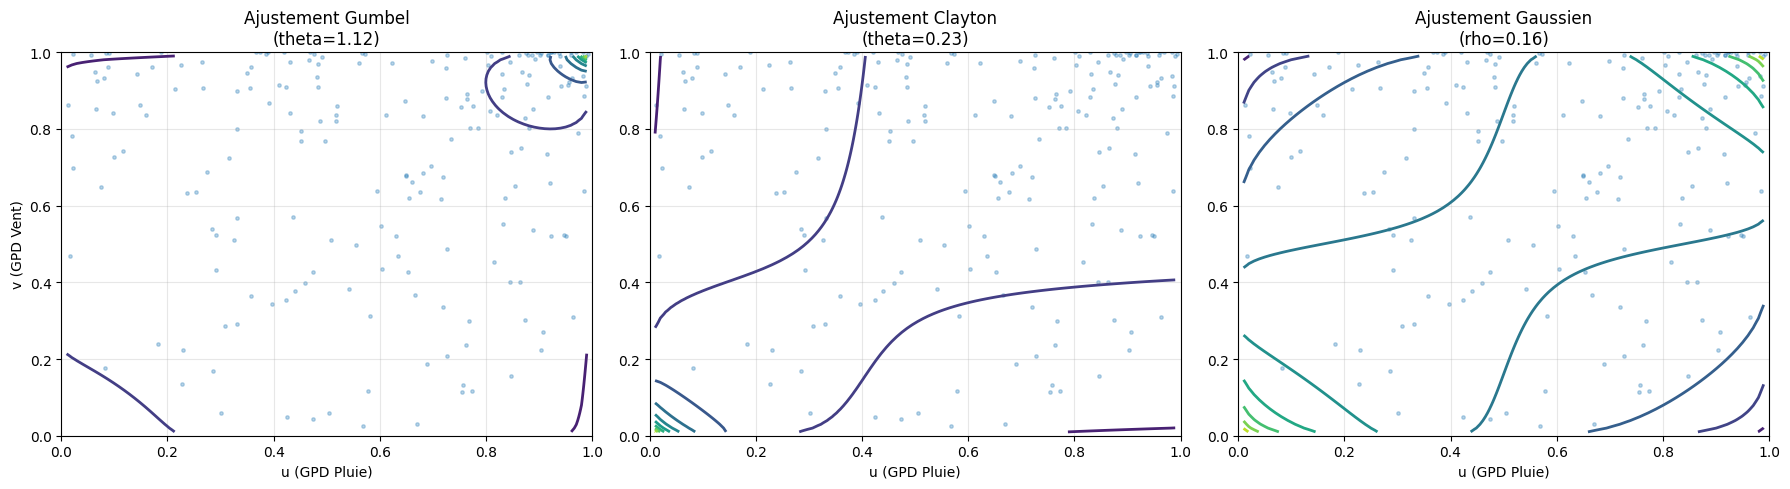

In [91]:
# u,v = extrêmes conjoints GPD
u = np.asarray(U_conjoint)
v = np.asarray(V_conjoint)
mask = np.isfinite(u) & np.isfinite(v)
u = u[mask]; v = v[mask]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# GUMBEL
axes[0].scatter(u, v, s=6, alpha=0.3, label='Extrêmes conjoints (GPD)')
Z_g = pdf_gumbel(U_grid, V_grid, theta_gumbel)
axes[0].contour(U_grid, V_grid, Z_g, levels=10, linewidths=2)
axes[0].set_title(f"Ajustement Gumbel\n(theta={theta_gumbel:.2f})")
axes[0].set_xlabel("u (GPD Pluie)")
axes[0].set_ylabel("v (GPD Vent)")

# CLAYTON
axes[1].scatter(u, v, s=6, alpha=0.3, label='Extrêmes conjoints (GPD)')
Z_c = pdf_clayton(U_grid, V_grid, theta_clayton)
axes[1].contour(U_grid, V_grid, Z_c, levels=10, linewidths=2)
axes[1].set_title(f"Ajustement Clayton\n(theta={theta_clayton:.2f})")
axes[1].set_xlabel("u (GPD Pluie)")

# GAUSS
axes[2].scatter(u, v, s=6, alpha=0.3, label='Extrêmes conjoints (GPD)')
Z_n = pdf_gauss(U_grid, V_grid, rho_gauss)
axes[2].contour(U_grid, V_grid, Z_n, levels=10, linewidths=2)
axes[2].set_title(f"Ajustement Gaussien\n(rho={rho_gauss:.2f})")
axes[2].set_xlabel("u (GPD Pluie)")

for ax in axes:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


*Vue en 3D*

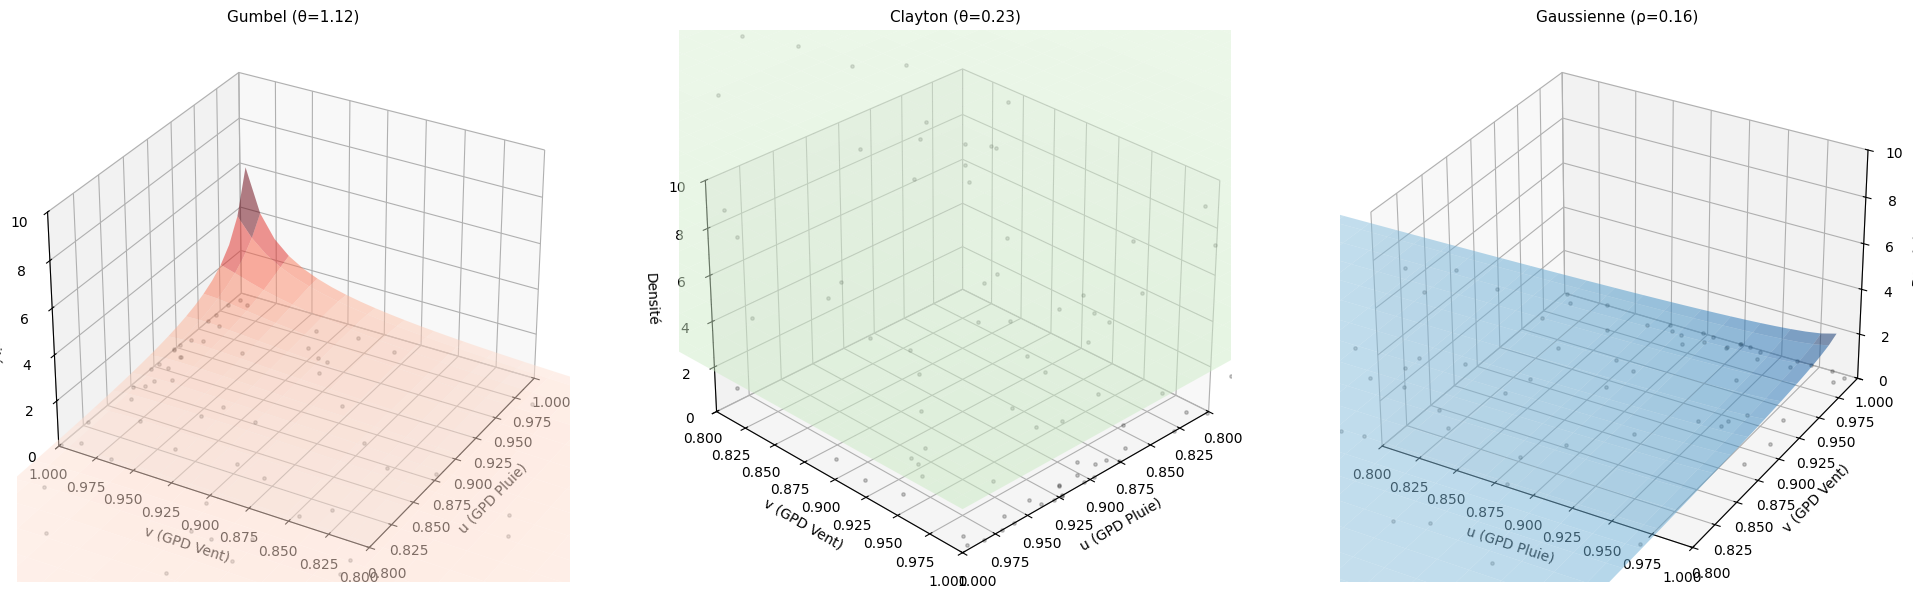

In [92]:
# 0) u,v = extrêmes conjoints GPD
u = np.asarray(U_conjoint)
v = np.asarray(V_conjoint)
mask = np.isfinite(u) & np.isfinite(v)
u = u[mask]; v = v[mask]

# 1) Préparation : écrêtage des pics
z_cap = 10
Z_g_cap = np.clip(Z_g, 0, z_cap)
Z_c_cap = np.clip(Z_c, 0, z_cap)
Z_n_cap = np.clip(Z_n, 0, z_cap)

# Optionnel : zoom pour l’analyse de queue (recommandé)
zoom_tail = True
if zoom_tail:
    xlim = (0.8, 1.0)
    ylim = (0.8, 1.0)
else:
    xlim = (0.0, 1.0)
    ylim = (0.0, 1.0)

# 2) Tracé 3D avec données
fig = plt.figure(figsize=(20, 6))

scatter_params = {'s': 6, 'c': 'black', 'alpha': 0.20, 'depthshade': False}

# GUMBEL (queue supérieure)
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(U_grid, V_grid, Z_g_cap, cmap='Reds', linewidth=0, antialiased=True, alpha=0.5)
ax1.scatter(u, v, zs=0, zdir='z', **scatter_params)

ax1.set_title(f"Gumbel (θ={theta_gumbel:.2f})", fontsize=11)
ax1.set_xlabel("u (GPD Pluie)")
ax1.set_ylabel("v (GPD Vent)")
ax1.set_zlabel("Densité")
ax1.set_xlim(*xlim); ax1.set_ylim(*ylim)
ax1.set_zlim(0, z_cap)
ax1.view_init(elev=30, azim=210)  # vue sur coin (1,1)

# CLAYTON (queue inférieure) — pas très pertinent si tu ne gardes que la queue haute
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(U_grid, V_grid, Z_c_cap, cmap='Greens', linewidth=0, antialiased=True, alpha=0.5)
ax2.scatter(u, v, zs=0, zdir='z', **scatter_params)

ax2.set_title(f"Clayton (θ={theta_clayton:.2f})", fontsize=11)
ax2.set_xlabel("u (GPD Pluie)")
ax2.set_ylabel("v (GPD Vent)")
ax2.set_zlabel("Densité")
ax2.set_xlim(*xlim); ax2.set_ylim(*ylim)
ax2.set_zlim(0, z_cap)
ax2.view_init(elev=30, azim=45)   # (0,0) — si zoom tail, tu verras peu de chose

# GAUSS (symétrique)
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(U_grid, V_grid, Z_n_cap, cmap='Blues', linewidth=0, antialiased=True, alpha=0.5)
ax3.scatter(u, v, zs=0, zdir='z', **scatter_params)

ax3.set_title(f"Gaussienne (ρ={rho_gauss:.2f})", fontsize=11)
ax3.set_xlabel("u (GPD Pluie)")
ax3.set_ylabel("v (GPD Vent)")
ax3.set_zlabel("Densité")
ax3.set_xlim(*xlim); ax3.set_ylim(*ylim)
ax3.set_zlim(0, z_cap)
ax3.view_init(elev=30, azim=-60)

plt.tight_layout()
plt.show()


### Calcul du critère log-vraisemblance:

In [93]:
def loglik_from_pdf(pdf_vals):
    pdf_vals = np.asarray(pdf_vals)
    pdf_vals = np.clip(pdf_vals, 1e-300, np.inf)  # évite log(0)
    return np.sum(np.log(pdf_vals))

# ----------------------------------------------------
# sécurité sur u,v (extrêmes conjoints GPD)
eps = 1e-12
u = np.asarray(U_conjoint)
v = np.asarray(V_conjoint)

mask = np.isfinite(u) & np.isfinite(v)
u = np.clip(u[mask], eps, 1 - eps)
v = np.clip(v[mask], eps, 1 - eps)

# ----------------------------------------------------
# Queue > 90% dans l'espace copulaire GPD (super-extrêmes)
mask_tail = (u > 0.90) & (v > 0.80)
u_tail, v_tail = u[mask_tail], v[mask_tail]

# ----------------------------------------------------
# LL globales (sur tous les extrêmes conjoints)
LL_gumbel  = loglik_from_pdf(pdf_gumbel(u, v, theta_gumbel))
LL_clayton = loglik_from_pdf(pdf_clayton(u, v, theta_clayton))
LL_gauss   = loglik_from_pdf(pdf_gauss(u, v, rho_gauss))

# LL queue (super-extrêmes)
LL_gumbel_tail  = np.nan if len(u_tail) == 0 else loglik_from_pdf(pdf_gumbel(u_tail, v_tail, theta_gumbel))
LL_clayton_tail = np.nan if len(u_tail) == 0 else loglik_from_pdf(pdf_clayton(u_tail, v_tail, theta_clayton))
LL_gauss_tail   = np.nan if len(u_tail) == 0 else loglik_from_pdf(pdf_gauss(u_tail, v_tail, rho_gauss))

# ----------------------------------------------------
# Affichage (inchangé dans l'esprit)
print("n_tail =", len(u_tail))
print("LL_gumbel =", LL_gumbel, " / tail =", LL_gumbel_tail)
print("LL_clayton =", LL_clayton, " / tail =", LL_clayton_tail)
print("LL_gauss =", LL_gauss, " / tail =", LL_gauss_tail)


n_tail = 24
LL_gumbel = -13.658772300416164  / tail = 9.366465301701943
LL_clayton = 3.044251442736506  / tail = 4.55898064595829
LL_gauss = 10.199905770425408  / tail = 15.060877910134723


## Joe copula

In [94]:
# Définir la zone “tempêtes” avec u_min et v_min
eps = 1e-12
u = np.clip(u, eps, 1-eps)
v = np.clip(v, eps, 1-eps)

u_min = 0.90
v_min = 0.80

mask_storm = (u >= u_min) & (v >= v_min)
u_storm = u[mask_storm]
v_storm = v[mask_storm]

print("nb points tempêtes (rectangle) =", len(u_storm))

nb points tempêtes (rectangle) = 24


In [95]:
# Estimer θ de Joe à partir de τ (sur tes u,v extrêmes conjoints)

tau, pval = kendalltau(u, v)
print(f"Tau (sur u,v) = {tau:.4f} (p={pval:.2g})")

def kendall_tau_joe(theta, K=3000):
    k = np.arange(1, K+1)
    series = np.sum(1.0 / (k * (k + 1) * (k + theta)))
    return 1 - (4 / theta) * series

def invert_tau_joe(tau_target):
    f = lambda th: kendall_tau_joe(th) - tau_target
    return brentq(f, 1.001, 60.0)  # Joe: theta >= 1

if tau <= 0:
    raise ValueError("Joe modélise une dépendance positive : il faut tau > 0.")

theta_joe = invert_tau_joe(tau)
print(f"Paramètre Joe estimé (theta) = {theta_joe:.3f}")

Tau (sur u,v) = 0.1046 (p=0.028)
Paramètre Joe estimé (theta) = 1.370


In [96]:
# Densité Joe + log-vraisemblance (globale + rectangle)
def loglik_from_pdf(pdf_vals):
    pdf_vals = np.asarray(pdf_vals)
    pdf_vals = np.clip(pdf_vals, 1e-300, np.inf)
    return np.sum(np.log(pdf_vals))

def pdf_joe(u, v, theta, eps=1e-12):
    u = np.clip(u, eps, 1 - eps)
    v = np.clip(v, eps, 1 - eps)

    A = (1 - u)**theta
    B = (1 - v)**theta
    C = A + B - A*B

    # Copule C(u,v)
    Cop = 1 - C**(1/theta)

    # Densité (formule standard)
    # c(u,v) = ( (1-u)^(θ-1) (1-v)^(θ-1) / ((1-u)(1-v)) ) * ...
    # Pour éviter les erreurs numériques, on écrit une forme stable :
    term1 = C**(1/theta - 2)
    term2 = (A * B) * (theta - 1 + C)  # (θ - 1 + C) apparaît dans certaines formes équivalentes

    dens = term1 * term2 / ((1 - u) * (1 - v))
    dens = np.clip(dens, 1e-300, np.inf)
    return dens

# LL globale (sur tous tes u,v)
LL_joe = loglik_from_pdf(pdf_joe(u, v, theta_joe))

# LL "tail" = sur ton rectangle u>=0.90, v>=0.80
LL_joe_tail = np.nan if len(u_storm) == 0 else loglik_from_pdf(pdf_joe(u_storm, v_storm, theta_joe))

print("LL_joe =", LL_joe, " / tail =", LL_joe_tail)

LL_joe = -79.7776524507031  / tail = -4.17178401019266


In [97]:
# Dépendance de queue de Joe (théorique)
lambda_u_joe = 2 - 2**(1/theta_joe)
lambda_l_joe = 0.0
print("lambda_u (Joe) =", lambda_u_joe, " / lambda_l =", lambda_l_joe)

lambda_u (Joe) = 0.3414433145456697  / lambda_l = 0.0


In [98]:
LL_gumbel_rect = np.nan if len(u_storm) == 0 else loglik_from_pdf(pdf_gumbel(u_storm, v_storm, theta_gumbel))
print("LL_gumbel (rectangle) =", LL_gumbel_rect)
print("ΔLL (Joe - Gumbel) =", (LL_joe_tail - LL_gumbel_rect) if len(u_storm)>0 else np.nan)

LL_gumbel (rectangle) = 9.366465301701943
ΔLL (Joe - Gumbel) = -13.538249311894603


In [99]:
print("n_tail =", len(u_storm))
print("LL_joe_tail par point =", LL_joe_tail / max(len(u_storm), 1))

n_tail = 24
LL_joe_tail par point = -0.1738243337580275


In [100]:
mask_sym = (u > 0.9) & (v > 0.8)
print("n_sym =", mask_sym.sum())
print("LL_joe_sym =", loglik_from_pdf(pdf_joe(u[mask_sym], v[mask_sym], theta_joe)) if mask_sym.sum()>0 else np.nan)

n_sym = 24
LL_joe_sym = -4.17178401019266


C_J min/max: 0.3378972221006471 153.4874084571908
levels: [1.03311446 1.34258351 1.43279039 1.59413924 1.91150417 2.51791204
 4.07686128]


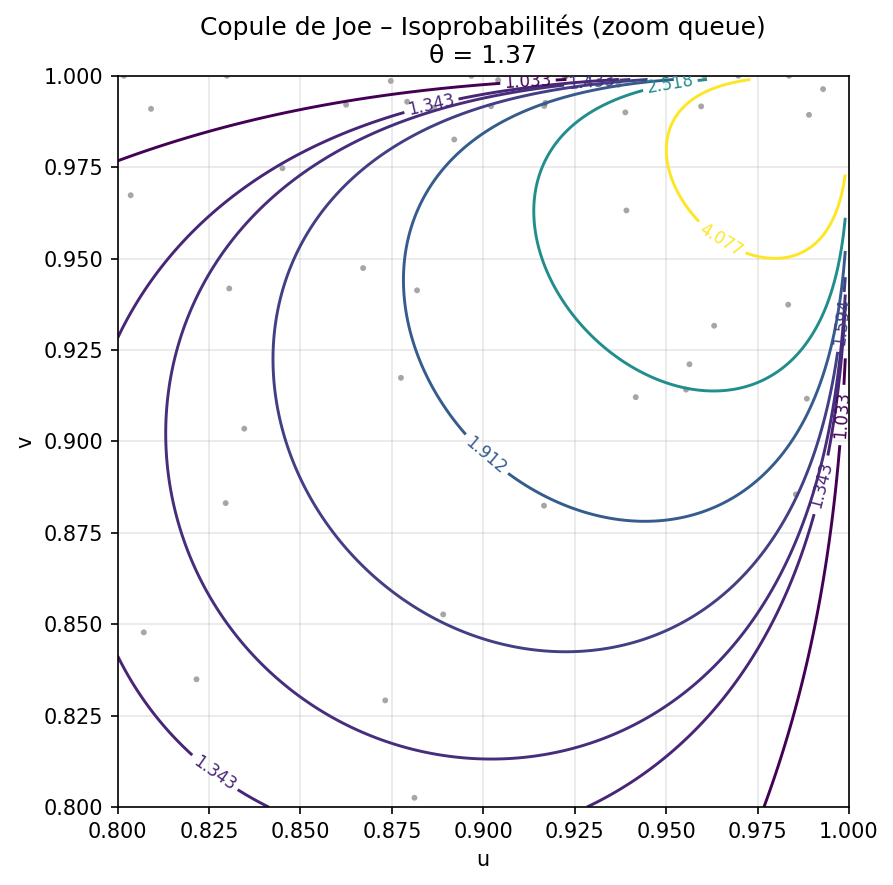

In [101]:
# 1) grille (zoom queue)
grid = np.linspace(0.8, 0.999, 400)
U_grid, V_grid = np.meshgrid(grid, grid)

# 2) valeurs de copule
C_J = pdf_joe(U_grid, V_grid, theta_joe)

# 3) niveaux auto (quantiles -> toujours dans la plage)
levels = np.quantile(C_J, [0.05, 0.15, 0.30, 0.50, 0.70, 0.85, 0.95])
levels = np.unique(levels)  # évite doublons si C_J est très "plat"
levels = levels[(levels > C_J.min()) & (levels < C_J.max())]  # garde niveaux strictement valides

print("C_J min/max:", float(C_J.min()), float(C_J.max()))
print("levels:", levels)

# 4) tracé
fig, ax = plt.subplots(figsize=(6.5, 6), dpi=150)
cs = ax.contour(U_grid, V_grid, C_J, levels=levels, linewidths=1.4)
ax.clabel(cs, fmt="%.3f", fontsize=8)

ax.scatter(u, v, s=8, alpha=0.35, color="black", edgecolors="none")

ax.set_aspect("equal")
ax.set_xlim(0.8, 1.0)
ax.set_ylim(0.8, 1.0)
ax.set_xlabel("u")
ax.set_ylabel("v")
ax.set_title(f"Copule de Joe – Isoprobabilités (zoom queue)\nθ = {theta_joe:.2f}")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [102]:
n = len(u)          # u = U_conjoint (extrêmes GPD)
print(n)

201


In [103]:
n = len(u)
k = 1  # une copule = 1 paramètre

AIC_gumbel  = -2 * LL_gumbel  + 2 * k
BIC_gumbel  = -2 * LL_gumbel  + k * np.log(n)

AIC_clayton = -2 * LL_clayton + 2 * k
BIC_clayton = -2 * LL_clayton + k * np.log(n)

AIC_gauss   = -2 * LL_gauss   + 2 * k
BIC_gauss   = -2 * LL_gauss   + k * np.log(n)

AIC_joe     = -2 * LL_joe     + 2 * k
BIC_joe     = -2 * LL_joe     + k * np.log(n)

In [104]:
n_tail = len(u_storm)

AIC_gumbel_tail  = -2 * LL_gumbel_tail  + 2 * k
BIC_gumbel_tail  = -2 * LL_gumbel_tail  + k * np.log(n_tail)

AIC_clayton_tail = -2 * LL_clayton_tail + 2 * k
BIC_clayton_tail = -2 * LL_clayton_tail + k * np.log(n_tail)

AIC_gauss_tail   = -2 * LL_gauss_tail   + 2 * k
BIC_gauss_tail   = -2 * LL_gauss_tail   + k * np.log(n_tail)

AIC_joe_tail     = -2 * LL_joe_tail     + 2 * k
BIC_joe_tail     = -2 * LL_joe_tail     + k * np.log(n_tail)

In [105]:
# 1. Dépendances de queue théoriques (lambda)

lambda_u_gumbel = 2 - 2**(1/theta_gumbel)
lambda_l_gumbel = 0.0

lambda_u_clayton = 0.0
lambda_l_clayton = 2**(-1/theta_clayton)

lambda_u_gauss = 0.0
lambda_l_gauss = 0.0

# Joe
lambda_u_joe = 2 - 2**(1/theta_joe)
lambda_l_joe = 0.0


# 2. Création du tableau (APRÈS calcul des LL)
data = {
    "Metrique": [
        "Paramètre estimé (theta/rho)",
        "Tau de Kendall (Théorique)",
        "Upper Tail Dep. (λu) [Tempêtes]",
        "Lower Tail Dep. (λl) [Calme]",
        "Log-Likelihood (Global)",
        "Log-Likelihood (u > 90% , v > 80%)"
    ],
    "Gumbel": [
        float(theta_gumbel),
        float(1 - 1/theta_gumbel),
        float(lambda_u_gumbel),
        float(lambda_l_gumbel),
        float(LL_gumbel),
        float(LL_gumbel_tail)
    ],
    "Clayton": [
        float(theta_clayton),
        float(theta_clayton / (theta_clayton + 2)),
        float(lambda_u_clayton),
        float(lambda_l_clayton),
        float(LL_clayton),
        float(LL_clayton_tail)
    ],
    "Gaussienne": [
        float(rho_gauss),
        float((2/np.pi) * np.arcsin(rho_gauss)),
        float(lambda_u_gauss),
        float(lambda_l_gauss),
        float(LL_gauss),
        float(LL_gauss_tail)
    ],
    "Joe": [
        float(theta_joe),
        float(kendall_tau_joe(theta_joe)),   # tau théorique Joe
        float(lambda_u_joe),
        float(lambda_l_joe),
        float(LL_joe),
        float(LL_joe_tail)
    ]
}

df_clean = pd.DataFrame(data).set_index("Metrique").round(3)

In [106]:
data["Metrique"] += ["AIC", "BIC"]

data["Gumbel"] += [AIC_gumbel, BIC_gumbel]
data["Clayton"] += [AIC_clayton, BIC_clayton]
data["Gaussienne"] += [AIC_gauss, BIC_gauss]
data["Joe"] += [AIC_joe, BIC_joe]

## Student Copula

In [107]:
# 1) Tau empirique sur (u,v)
tau, pval = kendalltau(u, v)

# Student copula (copule elliptique) : tau = 2/pi * arcsin(rho)  => rho = sin(pi*tau/2)
rho_student = float(np.sin((np.pi / 2) * tau))

print(f"Student: τ={tau:.3f} (p={pval:.2g})  ->  ρ={rho_student:.3f}")

Student: τ=0.105 (p=0.028)  ->  ρ=0.164


In [108]:
def clip01(a, eps=1e-12):
    return np.clip(np.asarray(a), eps, 1 - eps)

# PDF Student t bivariée (dim=2) avec corr [[1,rho],[rho,1]]
def biv_t_pdf(x, nu, rho):
    x = np.asarray(x)  # (n,2)
    det = 1 - rho**2
    inv = (1 / det) * np.array([[1, -rho], [-rho, 1]])
    Q = np.einsum("...i,ij,...j->...", x, inv, x)

    logC = (gammaln((nu + 2) / 2) - gammaln(nu / 2)
            - np.log(nu * np.pi) - 0.5 * np.log(det))
    logpdf = logC - ((nu + 2) / 2) * np.log1p(Q / nu)
    return np.exp(logpdf)

# densité de copule t (Student)
def pdf_student_copula(u, v, nu, rho):
    u = clip01(u); v = clip01(v)
    x = st.t.ppf(u, df=nu)
    y = st.t.ppf(v, df=nu)
    xy = np.column_stack([x, y])

    num = biv_t_pdf(xy, nu=nu, rho=rho)
    den = st.t.pdf(x, df=nu) * st.t.pdf(y, df=nu)

    c = num / np.clip(den, 1e-300, np.inf)
    return np.clip(c, 1e-300, np.inf)

def loglik(pdf_vals):
    pdf_vals = np.clip(pdf_vals, 1e-300, np.inf)
    return float(np.sum(np.log(pdf_vals)))

In [109]:
# Définir la zone “tempêtes” avec u_min et v_min
eps = 1e-12
u = np.clip(u, eps, 1-eps)
v = np.clip(v, eps, 1-eps)

u_min = 0.90
v_min = 0.80

mask_storm = (u >= u_min) & (v >= v_min)
u_storm = u[mask_storm]
v_storm = v[mask_storm]

print("nb points tempêtes (rectangle) =", len(u_storm))

nb points tempêtes (rectangle) = 24


In [110]:
from scipy.optimize import minimize_scalar

# Student : ρ est fixé via τ, on estime ν par MLE (1D)
def fit_nu_given_rho(u, v, rho, nu_min=2.01, nu_max=200.0):
    def neg_LL(nu):
        return -loglik(pdf_student_copula(u, v, nu, rho))
    res = minimize_scalar(neg_LL, bounds=(nu_min, nu_max), method="bounded")
    return float(res.x), res

nu_student, res_nu = fit_nu_given_rho(u, v, rho_student)
print(f"ν (ddl) estimé = {nu_student:.2f}")

# Dépendance de queue Student (symétrique haute=basse)
def lambda_u_student(nu, rho):
    a = np.sqrt((nu + 1) * (1 - rho) / (1 + rho))
    return float(2 * st.t.cdf(-a, df=nu + 1))

lambda_u_student_val = lambda_u_student(nu_student, rho_student)
lambda_l_student_val = lambda_u_student_val  # symétrique

print(f"λu Student = {lambda_u_student_val:.3f}")
print(f"λl Student = {lambda_l_student_val:.3f}")

# Log-likelihoods
LL_student = loglik(pdf_student_copula(u, v, nu_student, rho_student))
LL_student_tail = np.nan if len(u_storm)==0 else loglik(pdf_student_copula(u_storm, v_storm, nu_student, rho_student))

print("LL_student =", LL_student)
print("LL_student_tail =", LL_student_tail)

# (option) tau théorique cohérent avec rho
tau_student_theo = float((2/np.pi) * np.arcsin(rho_student))

ν (ddl) estimé = 200.00
λu Student = 0.000
λl Student = 0.000
LL_student = 9.860855350977063
LL_student_tail = 15.105680589664843


In [111]:
n = len(u)   # nombre d'observations utilisées

k_student = 2

AIC_student = 2*k_student - 2*LL_student
BIC_student = k_student*np.log(n) - 2*LL_student

In [112]:
data = {
    "Metrique": [
        "Paramètre estimé (theta/rho/nu)",
        "Tau de Kendall (Théorique)",
        "Upper Tail Dep. (λu) [Tempêtes]",
        "Lower Tail Dep. (λl) [Calme]",
        "Log-Likelihood (Global)",
        "Log-Likelihood (Queue > 90%)",
        "AIC",
        "BIC"
    ],
    "Gumbel": [
        float(theta_gumbel),
        float(1 - 1/theta_gumbel),
        float(lambda_u_gumbel),
        float(lambda_l_gumbel),
        float(LL_gumbel),
        float(LL_gumbel_tail),
        float(AIC_gumbel),
        float(BIC_gumbel)
    ],
    "Clayton": [
        float(theta_clayton),
        float(theta_clayton / (theta_clayton + 2)),
        float(lambda_u_clayton),
        float(lambda_l_clayton),
        float(LL_clayton),
        float(LL_clayton_tail),
        float(AIC_clayton),
        float(BIC_clayton)
    ],
    "Gaussienne": [
        float(rho_gauss),
        float((2/np.pi) * np.arcsin(rho_gauss)),
        float(lambda_u_gauss),
        float(lambda_l_gauss),
        float(LL_gauss),
        float(LL_gauss_tail),
        float(AIC_gauss),
        float(BIC_gauss)
    ],
    "Joe": [
        float(theta_joe),
        float(kendall_tau_joe(theta_joe)),
        float(lambda_u_joe),
        float(lambda_l_joe),
        float(LL_joe),
        float(LL_joe_tail),
        float(AIC_joe),
        float(BIC_joe)
    ],
    "Student": [
        f"ρ={rho_student:.3f}, ν={nu_student:.2f}",
        float(tau_student_theo),
        float(lambda_u_student_val),
        float(lambda_l_student_val),
        float(LL_student),
        float(LL_student_tail),
        float(AIC_student),
        float(BIC_student)
    ]
}

df_clean = pd.DataFrame(data).set_index("Metrique").round(3)
display(df_clean)

,Gumbel,Clayton,Gaussienne,Joe,Student
Metrique,,,,,
Paramètre estimé (theta/rho/nu),1.117,0.234,0.164,1.370,"ρ=0.164, ν=200.00"
Tau de Kendall (Théorique),0.105,0.105,0.105,0.105,0.104582
Upper Tail Dep. (λu) [Tempêtes],0.140,0.000,0.000,0.341,0.0
Lower Tail Dep. (λl) [Calme],0.000,0.051,0.000,0.000,0.0
Log-Likelihood (Global),-13.659,3.044,10.200,-79.778,9.860855
Log-Likelihood (Queue > 90%),9.366,4.559,15.061,-4.172,15.105681
AIC,29.318,-4.089,-18.400,161.555,-15.721711
BIC,32.621,-0.785,-15.097,164.859,-9.115101


# V/ De la copule à des niveaux de retour

## **A) Gauss**

In [113]:
time_joint = df_joint.index  # index time

dt = pd.DatetimeIndex(time_joint)
years = dt.year.to_numpy()
months = dt.month.to_numpy()

is_djf = np.isin(months, [12, 1, 2])

# DJF "year" : Décembre appartient à l'hiver suivant
djf_year = years.copy()
djf_year[months == 12] = djf_year[months == 12] + 1

n_days_djf_total = int(is_djf.sum())
n_seasons = len(np.unique(djf_year[is_djf]))

N_DJF = n_days_djf_total / n_seasons

print("Total jours DJF =", n_days_djf_total)
print("Nombre de saisons DJF =", n_seasons)
print("Jours DJF moyens par saison =", N_DJF)

Total jours DJF = 3940
Nombre de saisons DJF = 44
Jours DJF moyens par saison = 89.54545454545455


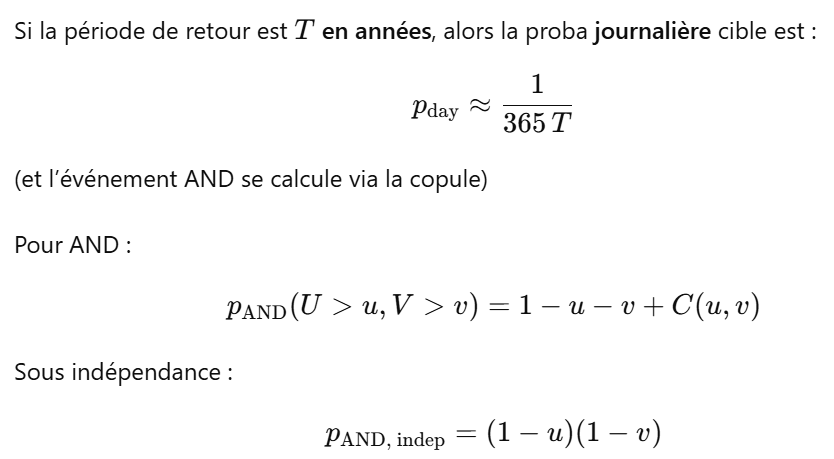

In [114]:
def C_gauss(u, v, rho, eps=1e-12):
    u = np.clip(u, eps, 1-eps)
    v = np.clip(v, eps, 1-eps)

    x = norm.ppf(u)
    y = norm.ppf(v)

    mean = [0.0, 0.0]
    cov = [[1.0, rho],
           [rho, 1.0]]

    # C(u,v) = Φ_ρ( Φ^{-1}(u), Φ^{-1}(v) )
    return multivariate_normal.cdf(np.column_stack([x, y]), mean=mean, cov=cov)

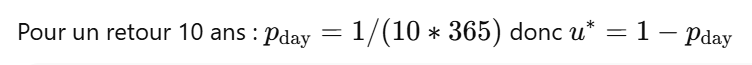

### 1.Seuil de 100 ans (calculé sur 1940-1980)

In [254]:
# seuils physiques qui est dépassé en 10 ans pour la période 1940-1980
x100 = 1096.714660730046
y100 = 1.017354328599085

#CDF GPD
u_star = genpareto.cdf(x100, c=c4, loc=loc4, scale=scale4)  # F_X(x100)
v_star = genpareto.cdf(y100, c=c5, loc=loc5, scale=scale5)  # F_Y(y100)

print("u_star =", u_star)
print("v_star =", v_star)


# Probabilité AND par jour (copule gaussienne)
C_uv = C_gauss(u_star, v_star, rho_gauss)
p_and_gauss_day = 1 - u_star - v_star + C_uv

# Indépendance
p_and_ind_day = (1-u_star)*(1-v_star)

# Périodes de retour (en années)
T_and_gauss_years = 1/(90*p_and_gauss_day)
T_and_ind_years   = 1/(90*p_and_ind_day)

# LMF
LMF_gauss = p_and_gauss_day / p_and_ind_day

print("p_AND (Gauss) par jour: p_and_gauss_day=", p_and_gauss_day)
print("p_AND (indep) par jour: p_and_ind_day =", p_and_ind_day)
print("Return period AND (Gauss) en années =", T_and_gauss_years)
print("Return period AND (indep) en années =", T_and_ind_years)
print("LMF (Gauss) =", LMF_gauss)


u_star = 0.9842214765702678
v_star = 0.6989968004229714
p_AND (Gauss) par jour: p_and_gauss_day= 0.007179638446251246
p_AND (indep) par jour: p_and_ind_day = 0.004749386036950498
Return period AND (Gauss) en années = 1.5475864410571583
Return period AND (indep) en années = 2.339483677398726
LMF (Gauss) = 1.5116982259166225


## 2. Student

In [119]:
def C_student(u, v, rho, nu, eps=1e-12):
    u = np.clip(u, eps, 1 - eps)
    v = np.clip(v, eps, 1 - eps)

    x = student_t.ppf(u, df=nu)
    y = student_t.ppf(v, df=nu)

    loc = np.array([0.0, 0.0])
    shape = np.array([[1.0, rho],
                      [rho, 1.0]])

    pts = np.column_stack([x, y])
    return multivariate_t.cdf(pts, loc=loc, shape=shape, df=nu)


In [121]:
# # Seuil univarié: "10 ans" (journalier)
# T1 = 10  # ans
# p_day_10 = 1 / (90 * T1)          # ton hypothèse : 90 jours/an
# u_star = 1 - p_day_10
# v_star = 1 - p_day_10

# print("p_day_10 =", p_day_10)
# print("u_star =", u_star, "v_star =", v_star)

# # Quantiles empiriques (seuils physiques)
# x10 = np.quantile(X, u_star)
# y10 = np.quantile(Y, v_star)
# print("Seuil X (10 ans) =", x10)
# print("Seuil Y (10 ans) =", y10)

# # --- paramètres copule Student ---
# rho_student = rho_student  # (déjà estimé chez toi)
# nu_student  = nu_student   # <-- A DEFINIR (ex: 4, 6, 10... ou estimé par MLE)

# # Probabilité AND par jour (copule studentienne)
# C_uv = float(C_student(u_star, v_star, rho=rho_student, nu=nu_student))
# p_and_student_day = 1 - u_star - v_star + C_uv

# # Indépendance
# p_and_ind_day = (1 - u_star) * (1 - v_star)

# # Sécurité numérique (évite division par 0 si très petit)
# eps = 1e-300
# p_and_student_day = max(p_and_student_day, eps)
# p_and_ind_day     = max(p_and_ind_day, eps)

# # Périodes de retour (en années)
# T_and_student_years = 1 / (90 * p_and_student_day)
# T_and_ind_years     = 1 / (90 * p_and_ind_day)

# # LMF
# LMF_student = p_and_student_day / p_and_ind_day

# print("p_AND (student) par jour =", p_and_student_day)
# print("p_AND (indep)   par jour =", p_and_ind_day)
# print("Return period AND (student) en années =", T_and_student_years)
# print("Return period AND (indep)   en années =", T_and_ind_years)
# print("LMF (student) =", LMF_student)


p_day_10 = 0.0011111111111111111
u_star = 0.9988888888888889 v_star = 0.9988888888888889
Seuil X (10 ans) = 1588.9087
Seuil Y (10 ans) = 15.027168
p_AND (student) par jour = 9.55354316267698e-06
p_AND (indep)   par jour = 1.2345679012344603e-06
Return period AND (student) en années = 1163.035632111771
Return period AND (indep)   en années = 9000.000000000784
LMF (student) = 7.7383699617690285


### 100 ans

In [258]:
# seuils physiques qui est dépassé en 10 ans pour la période 1940-1980
x100 = 1101.9825845568414
y100 = 1.017474482681099

#CDF GPD
u_star = genpareto.cdf(x100, c=c4, loc=loc4, scale=scale4)  # F_X(x100)
v_star = genpareto.cdf(y100, c=c5, loc=loc5, scale=scale5)  # F_Y(y100)

print("u_star =", u_star)
print("v_star =", v_star)


# Probabilité AND par jour (copule gaussienne)
C_uv = C_student(u_star, v_star, rho=rho_student, nu=nu_student)
p_and_gauss_day = 1 - u_star - v_star + C_uv

# Indépendance
p_and_ind_day = (1-u_star)*(1-v_star)

# Périodes de retour (en années)
T_and_gauss_years = 1/(90*p_and_gauss_day)
T_and_ind_years   = 1/(90*p_and_ind_day)

# LMF
LMF_gauss = p_and_gauss_day / p_and_ind_day

print("p_AND (Gauss) par jour: p_and_gauss_day=", p_and_gauss_day)
print("p_AND (indep) par jour: p_and_ind_day =", p_and_ind_day)
print("Return period AND (Gauss) en années =", T_and_gauss_years)
print("Return period AND (indep) en années =", T_and_ind_years)
print("LMF (Gauss) =", LMF_gauss)


u_star = 0.9845573745037326
v_star = 0.6990453221428755
p_AND (Gauss) par jour: p_and_gauss_day= 0.007054732033616173
p_AND (indep) par jour: p_and_ind_day = 0.004647530381497374
Return period AND (Gauss) en années = 1.5749869815275868
Return period AND (indep) en années = 2.3907559927626023
LMF (Gauss) = 1.517952859803195
